In [4]:
!pip install catboost
!pip install category_encoders
!pip install optuna
#Импорт необходимых библиотек

#Для работы с данными
import pandas as pd
import numpy as np

#Для кодирования данных
import category_encoders as ce

#МО
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn import feature_selection
from sklearn import metrics
import optuna
import xgboost as xgb
import catboost

#Для сериализации
import joblib

#Для визуализации
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('seaborn-v0_8')


#Ядро случайности
random_seed = 42

# **<center>Предсказание цен на аренду недвижимости в Москве</center>**

## Описание задачи:

Необходимо реализовать сервис, который будет помогать выставлять ценник на аренду квартиры в Москве. Сервис будет представлен в виде Telegram-бота. Обучаться модель будет на данных, взятых с базы объявлений недвижимости - Циан, вы можете взять готовые данные или собрать их самостоятельно, используя парсер из репозитория.

## Знакомство с данными и их очистка

Считываем наши данные.

In [5]:
data = pd.read_csv('/content/cyan_data.csv')
print(f'Размер таблицы: {data.shape}')
data.head()

Размер таблицы: (1500, 19)


,Дата создания объявления,Этаж,Кол-во этажей,Площадь,Жилая площадь,Площадь кухни,Кол-во комнат,Наличие мебели,Адрес,Округ,"Ближайшее метро, мин.","Ближайший вокзал, мин.","Стоимость, мес.",Кол-во балконов,Продажа от агента,Год постройки здания,Кол-во грузовых лифтов,Кол-во пассажирских лифтов,Парковка
0,2024-11-12T20:27:58.11,20,23,75.0,45.5,10.0,3,True,"Москва, ул. Берзарина, д. 30",СЗАО,4,-1,168800,0,True,-1,1,1,underground
1,2024-11-15T20:09:15.127,3,10,173.0,130.0,24.0,3,True,"Москва, Фадеева ул., 4A",ЦАО,8,-1,950000,0,True,-1,0,1,underground
2,2024-11-22T18:54:53.14,23,23,42.0,18.0,9.0,1,True,"Москва, Внуковское п, Внуково п, Анны Ахматово...",НАО (Новомосковский),2,-1,60000,0,True,-1,0,3,-1
3,2024-10-16T16:24:47.157,8,10,125.0,72.0,16.0,3,True,"Москва, 2-ая Тверская-Ямская ул., 26",ЦАО,3,15,400000,0,True,-1,0,1,underground
4,2024-10-31T16:57:12.693,45,75,120.0,-1.0,-1.0,3,True,"Россия, Москва, 1-й Красногвардейский проезд, 15",ЦАО,3,10,570000,0,True,2013,2,4,underground


Удаляем признаки, которые не несут полезной информации.

In [6]:
data = data.drop('Дата создания объявления', axis=1)
data.head()

,Этаж,Кол-во этажей,Площадь,Жилая площадь,Площадь кухни,Кол-во комнат,Наличие мебели,Адрес,Округ,"Ближайшее метро, мин.","Ближайший вокзал, мин.","Стоимость, мес.",Кол-во балконов,Продажа от агента,Год постройки здания,Кол-во грузовых лифтов,Кол-во пассажирских лифтов,Парковка
0,20,23,75.0,45.5,10.0,3,True,"Москва, ул. Берзарина, д. 30",СЗАО,4,-1,168800,0,True,-1,1,1,underground
1,3,10,173.0,130.0,24.0,3,True,"Москва, Фадеева ул., 4A",ЦАО,8,-1,950000,0,True,-1,0,1,underground
2,23,23,42.0,18.0,9.0,1,True,"Москва, Внуковское п, Внуково п, Анны Ахматово...",НАО (Новомосковский),2,-1,60000,0,True,-1,0,3,-1
3,8,10,125.0,72.0,16.0,3,True,"Москва, 2-ая Тверская-Ямская ул., 26",ЦАО,3,15,400000,0,True,-1,0,1,underground
4,45,75,120.0,-1.0,-1.0,3,True,"Россия, Москва, 1-й Красногвардейский проезд, 15",ЦАО,3,10,570000,0,True,2013,2,4,underground


### **Описание признаков**

|Признак | Описание|Тип данных|
|---|---|---|
|Этаж|Номер этажа, на котором находится квартира|Категориальный|
|Кол-во этажей|Кол-во этажей в здании|Категориальный|
|Площадь|Общая площадь квартиры|Числовой|
|Жилая площадь|Жилая площадь в квартире|Числовой|
|Площадь кухни|Площадь кухни в квартире|Числовой|
|Кол-во комнат|Кол-во комнат в квартире|Категориальный|
|Наличие мебели|Показатель того, есть ли в квартире мебель или нет|Категориальный|
|Адрес|Адрес, по которому находится квартира|Категориальный|
|Округ|Округ, в котором находится квартира|Категориальный|
|Ближайшее метро, мин.|Время, которое надо затратить, чтобы дойти до метро пешком|Числовой|
|Ближайший вокзал, мин.|Время, которое надо затратить, чтобы дойти до вокзала пешком|Числовой|
|Стоимость, мес.|Стоимость квартиры в месяц, целевая переменная|Числовой|
|Кол-во балконов|Сколько балконов находится в квартире|Категориальный|
|Продажа от агента|Продает агент или собственник|Категориальный|
|Год постройки здания|Год, в котором построили здание|Числовой|
|Кол-во грузовых лифтов|Кол-во грузовых лифтов в здании, где находится квартире|Категориальный|
|Кол-во пассажирских лифтов|Кол-во пассажирских лифтов в здании, где находится квартире|Категориальный|
|Парковка|Тип парковки|Категориальный|

В данных пропуски представлены значением -1, давайте исправим их на значения None для удобства.

In [7]:
for column in data.columns:
    data[column] = data[column].apply(lambda x: None if x == -1 or x == '-1' else x)

Посмотрим на основную информацию о данных.

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 18 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Этаж                        1500 non-null   int64  
 1   Кол-во этажей               1500 non-null   int64  
 2   Площадь                     1500 non-null   float64
 3   Жилая площадь               1094 non-null   float64
 4   Площадь кухни               1214 non-null   float64
 5   Кол-во комнат               1500 non-null   int64  
 6   Наличие мебели              1500 non-null   bool   
 7   Адрес                       1500 non-null   object 
 8   Округ                       1500 non-null   object 
 9   Ближайшее метро, мин.       1498 non-null   float64
 10  Ближайший вокзал, мин.      514 non-null    float64
 11  Стоимость, мес.             1500 non-null   int64  
 12  Кол-во балконов             1500 non-null   int64  
 13  Продажа от агента           1500 

Проверим данные на дубликаты.

In [9]:
data.duplicated().sum()

100

В данных присутствует 100 дубликатов, удалим их.

In [10]:
data = data.drop_duplicates()
f'Размер таблицы: {data.shape}'

'Размер таблицы: (1400, 18)'

### **Заполнение пропусков**

Заметим, что в наших данных присутствуют пропуски, удаляем те признаки, в которых пропусков более 70 процентов.

In [11]:
min_clean_count = 0.7 * data.shape[0]
data = data.dropna(thresh=min_clean_count, axis=1)
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1400 entries, 0 to 1499
Data columns (total 16 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Этаж                        1400 non-null   int64  
 1   Кол-во этажей               1400 non-null   int64  
 2   Площадь                     1400 non-null   float64
 3   Жилая площадь               1010 non-null   float64
 4   Площадь кухни               1128 non-null   float64
 5   Кол-во комнат               1400 non-null   int64  
 6   Наличие мебели              1400 non-null   bool   
 7   Адрес                       1400 non-null   object 
 8   Округ                       1400 non-null   object 
 9   Ближайшее метро, мин.       1398 non-null   float64
 10  Стоимость, мес.             1400 non-null   int64  
 11  Кол-во балконов             1400 non-null   int64  
 12  Продажа от агента           1400 non-null   bool   
 13  Кол-во грузовых лифтов      1400 non-n

Остается еще четыре признака с пропусками: "Жилая площадь", "Площадь кухни", "Ближайшее метро, мин" и "Парковка". Давайте заполним пропуски для каждого из них.

**"Жилая площадь"** - можем предположить, что если в признаке присутствует пропуск, то его жилая площадь равна площади квартиры. Тогда заполним пропуски соответствующим значением, из признака "Площадь".

Перед этим посмотрим на распределение признака:

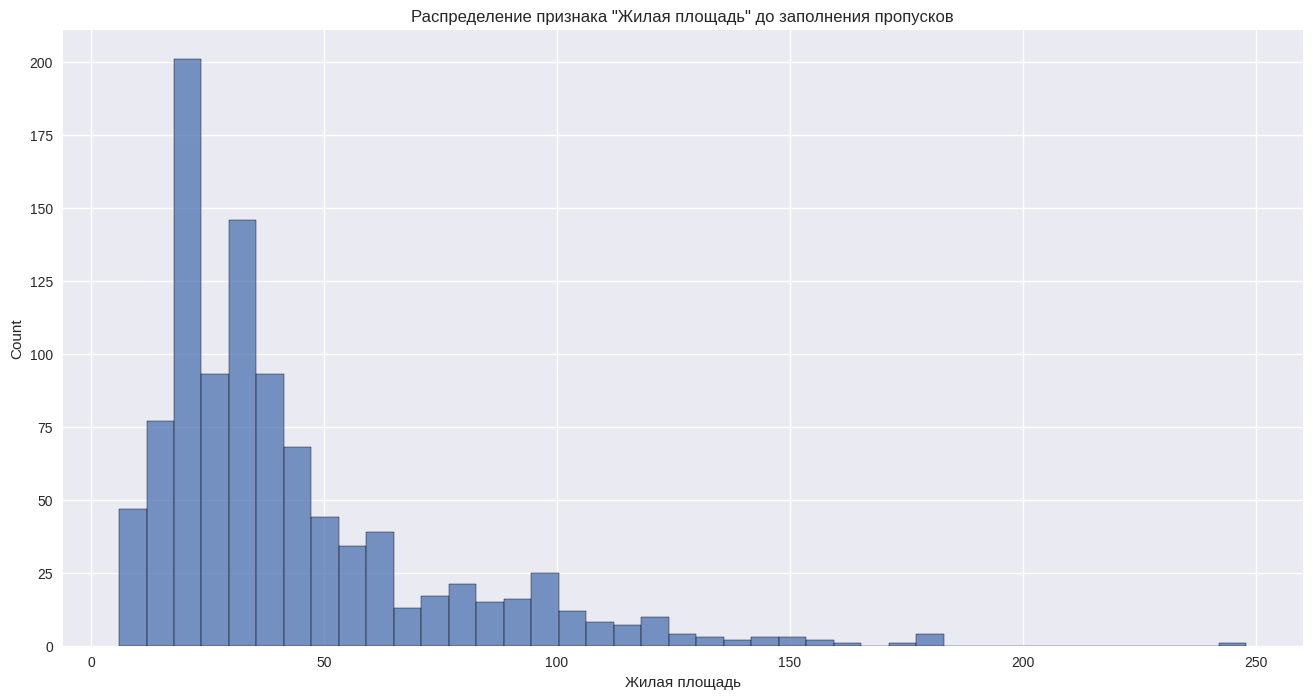

In [12]:
#Визуализируем гистограмму переменной
fig, ax = plt.subplots(1, 1, figsize=(16, 8))
sns.histplot(data=data, x='Жилая площадь', ax=ax)
ax.set_title('Распределение признака "Жилая площадь" до заполнения пропусков');

Заполняем пропуски.

In [13]:
for index, row in data.iterrows():
    if np.isnan(row['Жилая площадь']):
        data.loc[index,'Жилая площадь'] = row['Площадь']

data['Жилая площадь'].isnull().sum()

0

Теперь снова посмотрим на распределение.

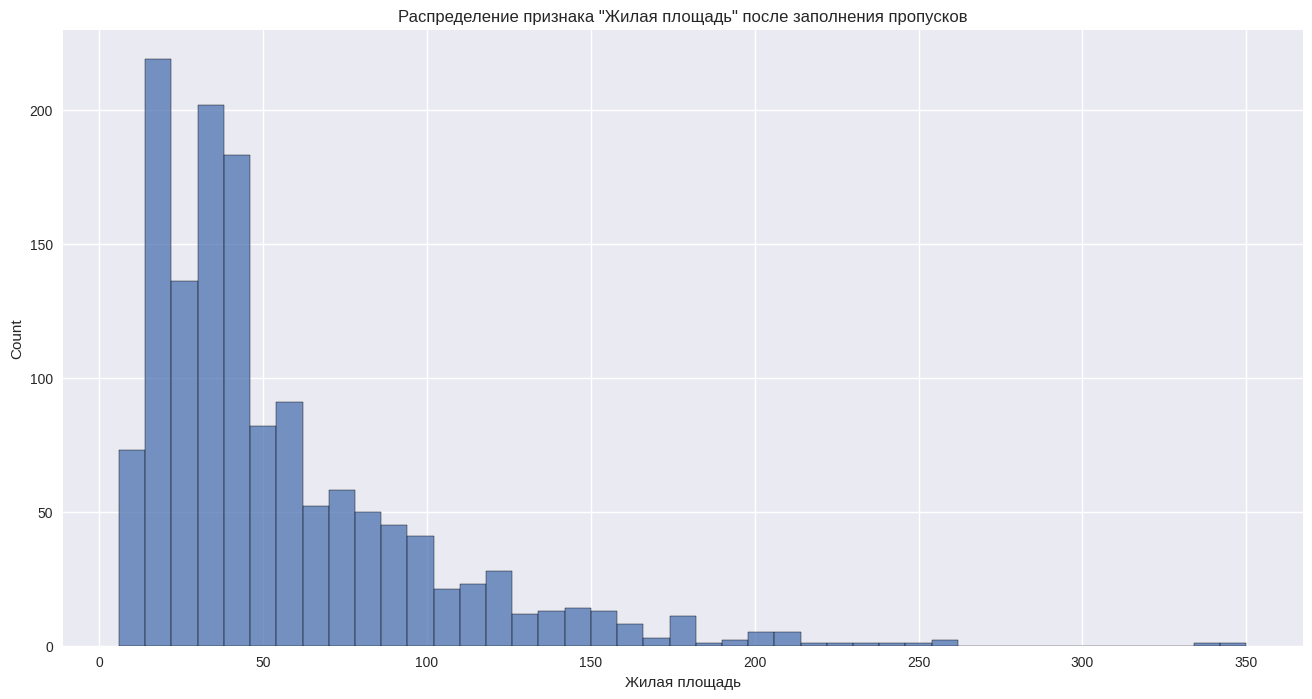

In [14]:
#Визуализируем гистограмму переменной
fig, ax = plt.subplots(1, 1, figsize=(16, 8))
sns.histplot(data=data, x='Жилая площадь', ax=ax)
ax.set_title('Распределение признака "Жилая площадь" после заполнения пропусков');

Можем наблюдать, что общая картина распределения осталась прежней.

**"Площадь кухни"** - все немного сложнее, мы не можем просто взять какую-то центральную величену, например, медиану, потому что тогда может получиться такое, что площадь кухни будет больше или равна площади квартиры, что противоречит какой-либо логике. Давайте поступим следующим образом: будем считать, если в признаке пропуск, то площадь кухни равна *Площадь / Кол-во комнат*.

Также посмотрим на распределение:

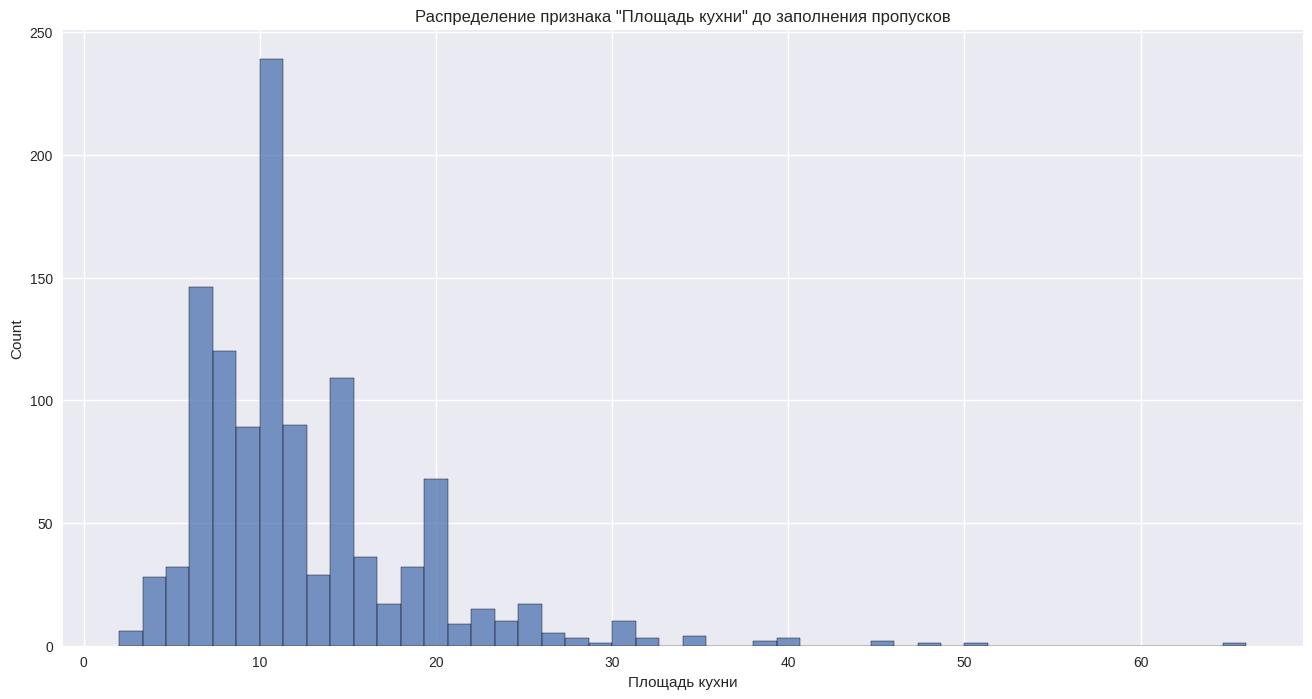

In [15]:
#Визуализируем гистограмму переменной
fig, ax = plt.subplots(1, 1, figsize=(16, 8))
sns.histplot(data=data, x='Площадь кухни', ax=ax)
ax.set_title('Распределение признака "Площадь кухни" до заполнения пропусков');

Избавляемся от пропусков.

In [16]:
for index, row in data.iterrows():
    if np.isnan(row['Площадь кухни']):
        data.at[index,'Площадь кухни'] = row['Площадь'] / row['Кол-во комнат']

data['Площадь кухни'].isnull().sum()

0

Смотрим на распределение.

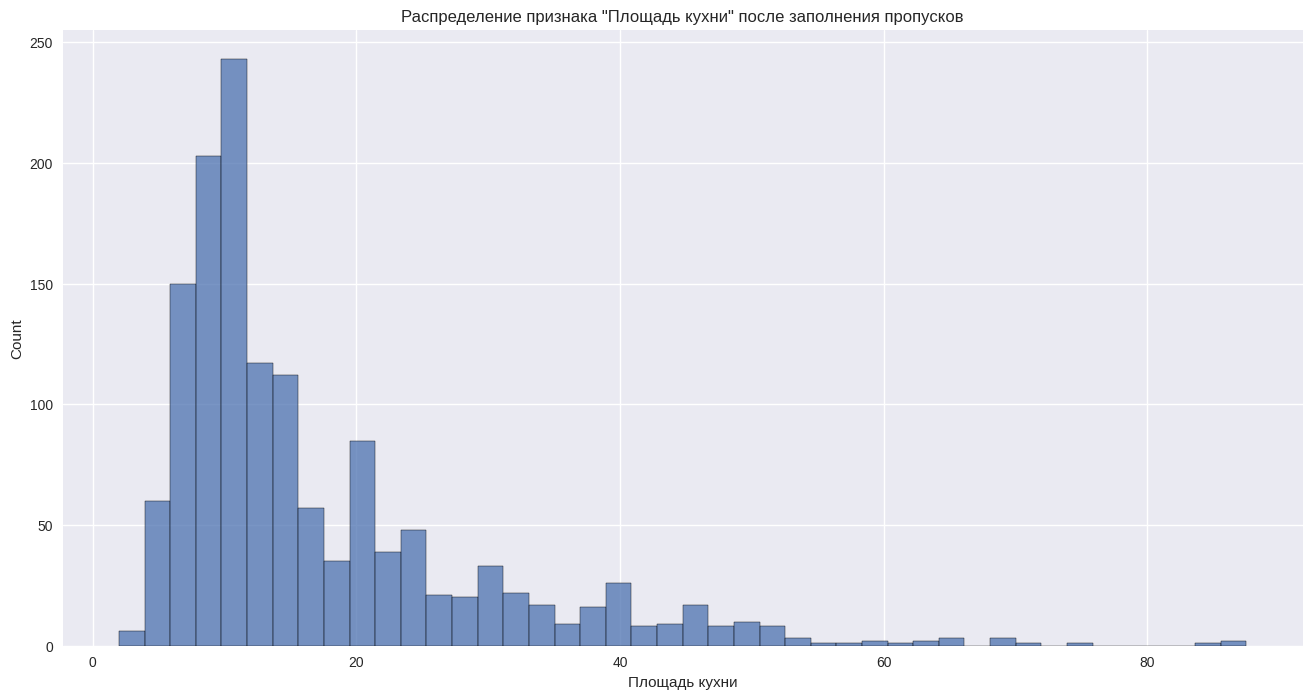

In [17]:
#Визуализируем гистограмму переменной
fig, ax = plt.subplots(1, 1, figsize=(16, 8))
sns.histplot(data=data, x='Площадь кухни', ax=ax)
ax.set_title('Распределение признака "Площадь кухни" после заполнения пропусков');

График стал выглядеть иначе, но общий характер сильно не пострадал, поэтому такое заполнение признака на мой взгляд является оптимальным.

**"Ближайшее метро, мин."** - в этом признаке всего два пропуска, заполним их вручную: просто посмотрим по картам сколько добираться до метро.

In [18]:
#Заменяем пропуски на -1
data['Ближайшее метро, мин.'] = data['Ближайшее метро, мин.'].apply(lambda x: -1 if np.isnan(x) else x)

#Посмотрим, в каких адресах пропуски у этого признака.
mask = data['Ближайшее метро, мин.'] == -1
data[mask]['Адрес']

,Адрес
982,"Россия, Москва, район Троицк, улица Яворки, 1к6"
1477,"Россия, Москва, Бирюлёвская улица, 45к1"


In [19]:
data['Ближайшее метро, мин.'].value_counts()

,count
"Ближайшее метро, мин.",
4.0,253
5.0,225
6.0,153
3.0,134
7.0,127
8.0,98
10.0,89
12.0,52
11.0,51


Теперь воспользуемся картами в интернете и посмотрим сколько минимум добираться до метро:

    Россия, Москва, район Троицк, улица Яворки, 1к6 - 210 минут.
    Россия, Москва, Бирюлёвская улица, 45к1 - 74 минуты.

Заполняем пропуски и удаляем признак "Адрес", так как он не несет никакой полезной информации.

In [20]:
#Произоводим замену значений в конкретных ячейках.
data.at[982, 'Ближайшее метро, мин.'] = 210
data.at[1477, 'Ближайшее метро, мин.'] = 74
data['Ближайшее метро, мин.'].value_counts()

,count
"Ближайшее метро, мин.",
4.0,253
5.0,225
6.0,153
3.0,134
7.0,127
8.0,98
10.0,89
12.0,52
11.0,51


Удаляем признак.

In [21]:
data = data.drop('Адрес', axis=1)

**Парковка** - заполняем пропуски модой.

In [22]:
data['Парковка'] = data['Парковка'].fillna(data['Парковка'].mode()[0])
data['Парковка'].value_counts()

,count
Парковка,
ground,880
underground,464
open,29
multilevel,27


Убедимся, что в данных не осталось пропусков.

In [23]:
f'Кол-во пропусков в данных: {data.isnull().sum().sum()}'

'Кол-во пропусков в данных: 0'

## Разведовательный анализ данных

На этом этапе мы посмотрим, как целевая переменныя зависит от остальных признаков, попытаемся обнаружить выбросы и избавиться от них. Также, если получится, то займемся генерацией признаков и статистическими тестами для проверки гипотез.

### **Целевая переменная**

Давайте взглянем на распределение нашего таргета:

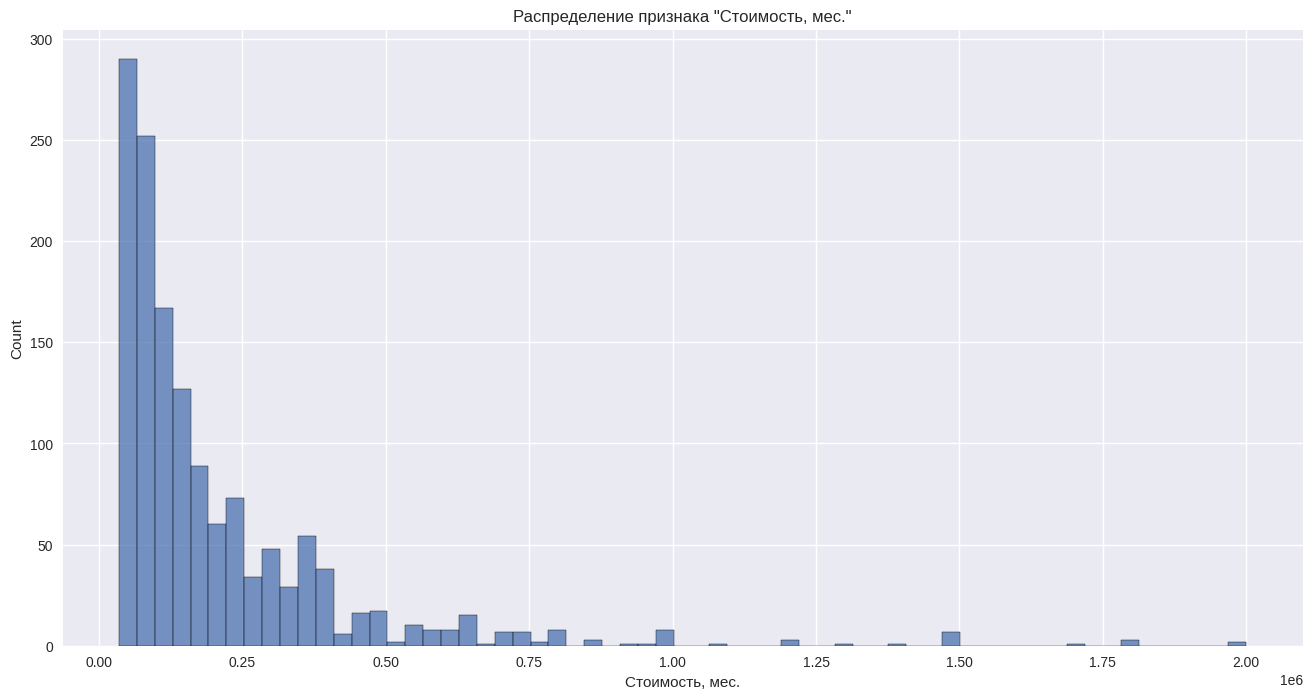

In [24]:
#Визуализируем гистограмму целевой переменной
fig, ax = plt.subplots(1, 1, figsize=(16, 8))
sns.histplot(data=data, x='Стоимость, мес.', ax=ax)
ax.set_title('Распределение признака "Стоимость, мес."');

Распределение признака напоминает логарифмическое, давайте попробуем привести его к нормальному виду.

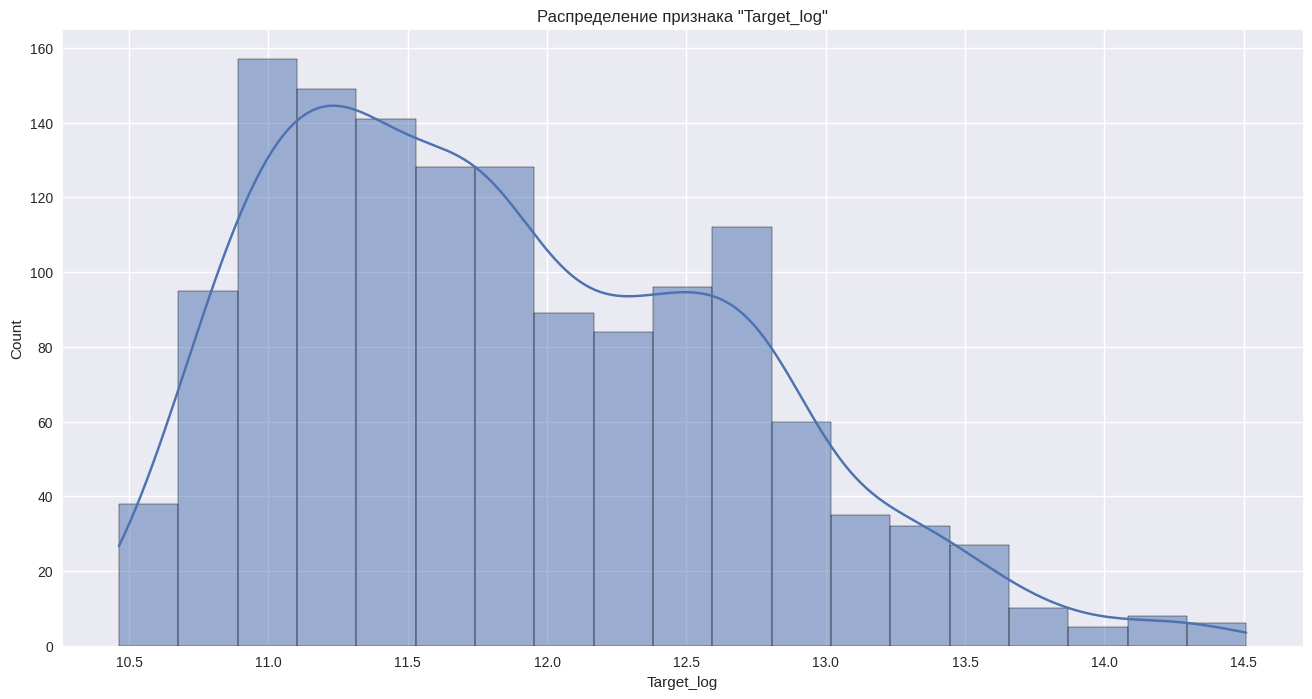

In [25]:
data['Target_log'] = data['Стоимость, мес.'].apply(lambda x: np.log(x + 1))

#Визуализируем гистограмму логарифма от целевой переменной
fig, ax = plt.subplots(1, 1, figsize=(16, 8))
sns.histplot(data=data, x='Target_log', kde=True, ax=ax)
ax.set_title('Распределение признака "Target_log"');

Для удаления выбросов напишем следующую функцию, которая применяет метод Тьюки.

In [26]:
def tukey_method(data, feature, right=1.5, left=1.5, log_need=False):
    """Функция для удаления выбросов с помощью метода Тьюки

    Args:
        data (pandas.core.frame.DataFrame): Датафрейм с нашими данными
        feature (str): Признак, который мы хотим очистить
        right (float, optional): Для усов в право. Defaults to 1.5.
        left (float, optional): Длина усов в лево. Defaults to 1.5.
        log_need (bool, optional): Индикато, который отвечает за логарифмирование данных. Defaults to False.
    """
    if log_need: #Логарифмируем данные, если требуется
        X = np.log(data[feature] + 1)
    else:
        X = data[feature]
    #Рассчитываем квантили
    quantile_1 = X.quantile(0.25)
    quantile_2 = X.quantile(0.75)
    #Считаем межквартильный размах
    iqr = quantile_2 - quantile_1
    #Находим верхнюю и нижнюю границы
    lower_bound = quantile_1 - left * iqr
    upper_bound = quantile_2 + right * iqr
    #Очищаем данные
    data_cleaned = data[(X >= lower_bound) & (X <= upper_bound)]
    return data_cleaned

Удаляем выбросы.

Количество наблюдений после удаления выбросов: 1368


Text(0.5, 1.0, 'Распределение целевой переменной')

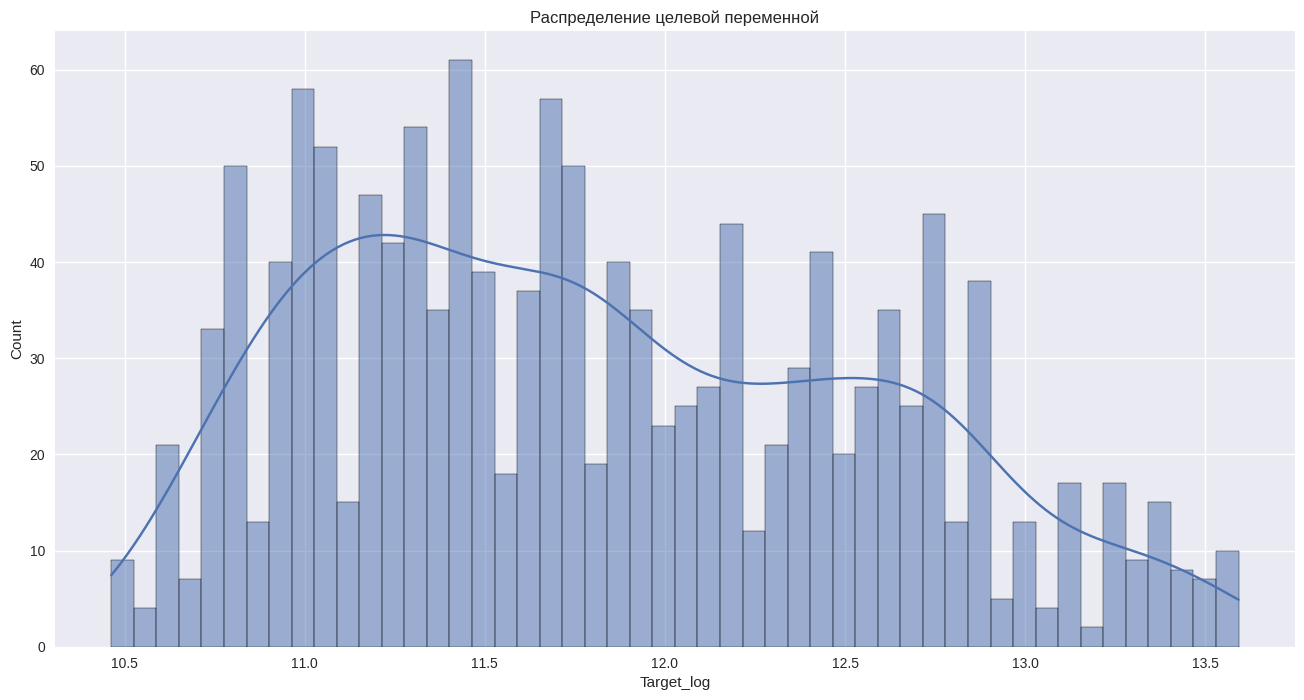

In [27]:
#Удаляем выбросы
data = tukey_method(data, 'Target_log', right=1)
print(f'Количество наблюдений после удаления выбросов: {data.shape[0]}')

#Визуализируем гистограмму целевой переменной
fig, ax = plt.subplots(1, 1, figsize=(16, 8))
sns.histplot(data=data, x='Target_log', bins=50, kde=True, ax=ax)
ax.set_title('Распределение целевой переменной')

### **Этаж и Кол-во этажей**

Давайте создадим новые признаки на основе этих: "Последний этаж", если квартира на последнем этаже здания, и "Первый этаж", если на первом.

In [28]:
def last_first_floor(data):
    #Создаем столбцы будущих признаков
    data['Последний этаж'] = np.zeros(data.shape[0])
    data['Первый этаж'] = np.zeros(data.shape[0])
    #Заполняем значения в соответствии логике, описанной выше
    for index, row in data.iterrows():
        if row['Этаж'] == row['Кол-во этажей']:
            data.at[index, 'Последний этаж'] = 1
        elif row['Этаж'] == 1:
            data.at[index, 'Первый этаж'] = 1
        else:
            pass
    #Возвращаем обновленную таблицу
    return data

#Генерируем новые признаки
data = last_first_floor(data)
data.head()

,Этаж,Кол-во этажей,Площадь,Жилая площадь,Площадь кухни,Кол-во комнат,Наличие мебели,Округ,"Ближайшее метро, мин.","Стоимость, мес.",Кол-во балконов,Продажа от агента,Кол-во грузовых лифтов,Кол-во пассажирских лифтов,Парковка,Target_log,Последний этаж,Первый этаж
0,20,23,75.0,45.5,10.0,3,True,СЗАО,4.0,168800,0,True,1,1,underground,12.036476,0.0,0.0
2,23,23,42.0,18.0,9.0,1,True,НАО (Новомосковский),2.0,60000,0,True,0,3,ground,11.002117,1.0,0.0
3,8,10,125.0,72.0,16.0,3,True,ЦАО,3.0,400000,0,True,0,1,underground,12.899222,0.0,0.0
4,45,75,120.0,120.0,40.0,3,True,ЦАО,3.0,570000,0,True,2,4,underground,13.253393,0.0,0.0
5,15,19,40.0,40.0,10.0,1,True,НАО (Новомосковский),4.0,65000,0,False,1,1,ground,11.082158,0.0,0.0


Посмотрим на распределения получившихся признаков.

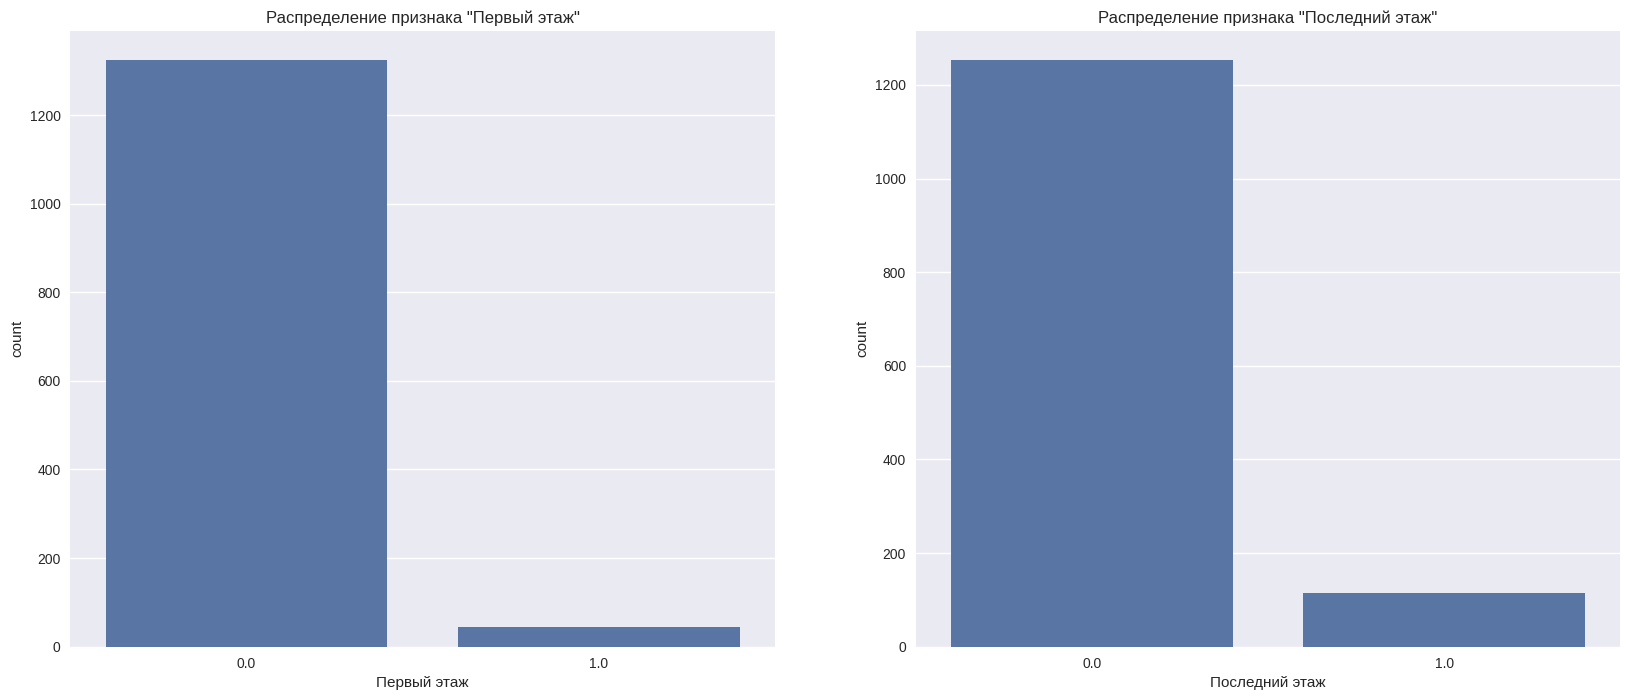

In [29]:
#Строим графики распределений признаков
fig, axes = plt.subplots(1, 2, figsize=(20, 8))
sns.countplot(data, x='Первый этаж', ax=axes[0])
axes[0].set_title('Распределение признака "Первый этаж"')
sns.countplot(data, x='Последний этаж', ax=axes[1])
axes[1].set_title('Распределение признака "Последний этаж"');

В признаках присутствует сильный дисбаланс классов - такое поведение является ожидаемым. Давайте посмотрим на целевую переменную в разрезе этих признаков.

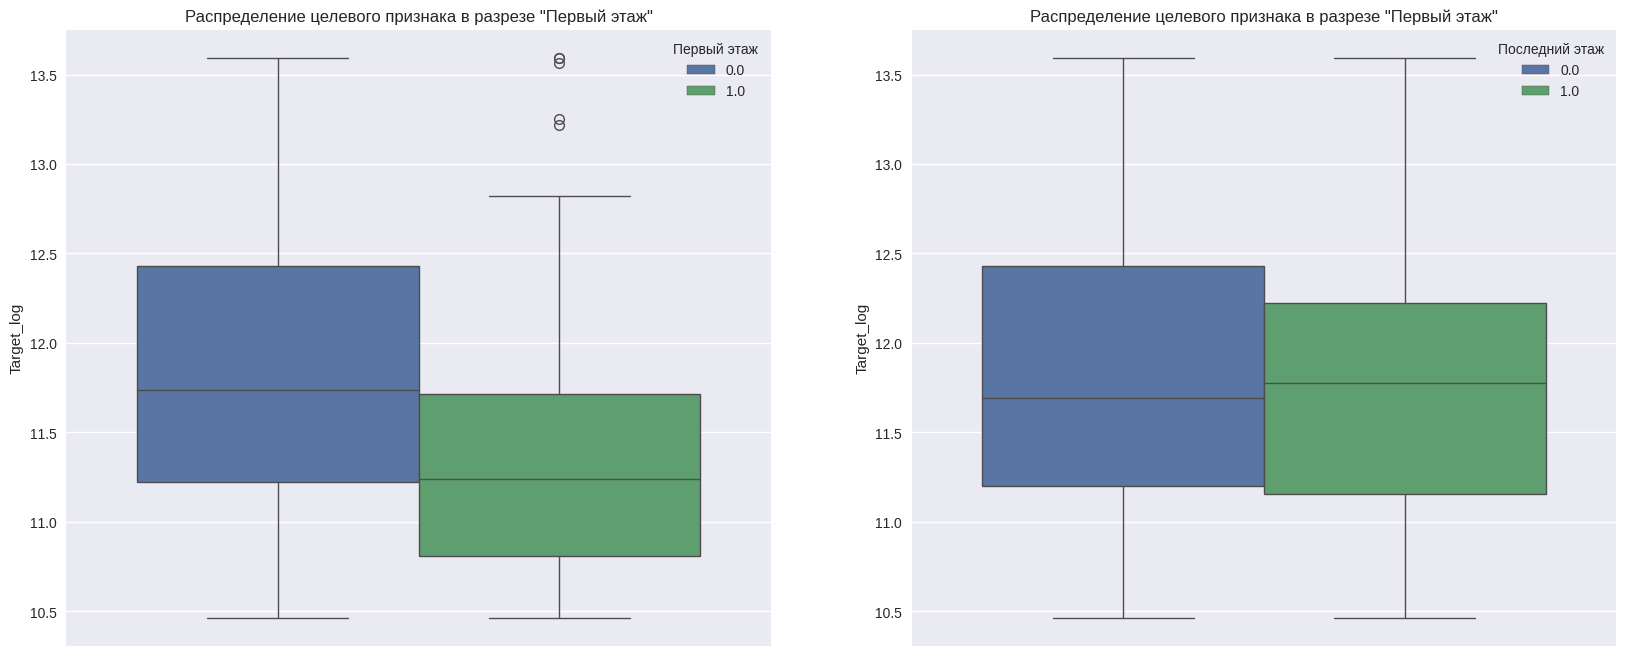

In [30]:
#Строим графики
fig, axes = plt.subplots(1, 2, figsize=(20, 8))
sns.boxplot(data, y='Target_log', hue='Первый этаж', ax=axes[0])
axes[0].set_title('Распределение целевого признака в разрезе "Первый этаж"')
sns.boxplot(data, y='Target_log', hue='Последний этаж', ax=axes[1])
axes[1].set_title('Распределение целевого признака в разрезе "Первый этаж"');

Зависисимость целевой переменной от кол-ва этажей в здании.

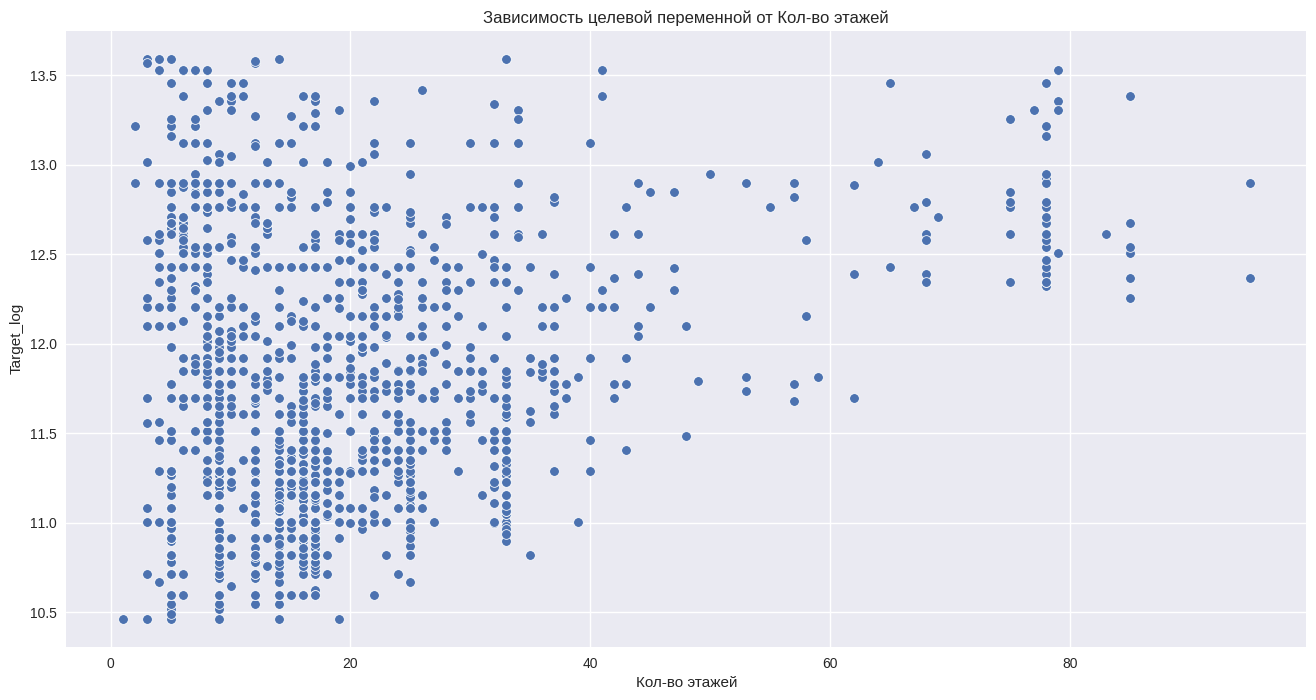

In [31]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))
sns.scatterplot(data=data, x='Кол-во этажей', y='Target_log', ax=ax)
ax.set_title('Зависимость целевой переменной от Кол-во этажей');

Также посмотрим на то, как завивисит целевая переменная от этажа квартиры.

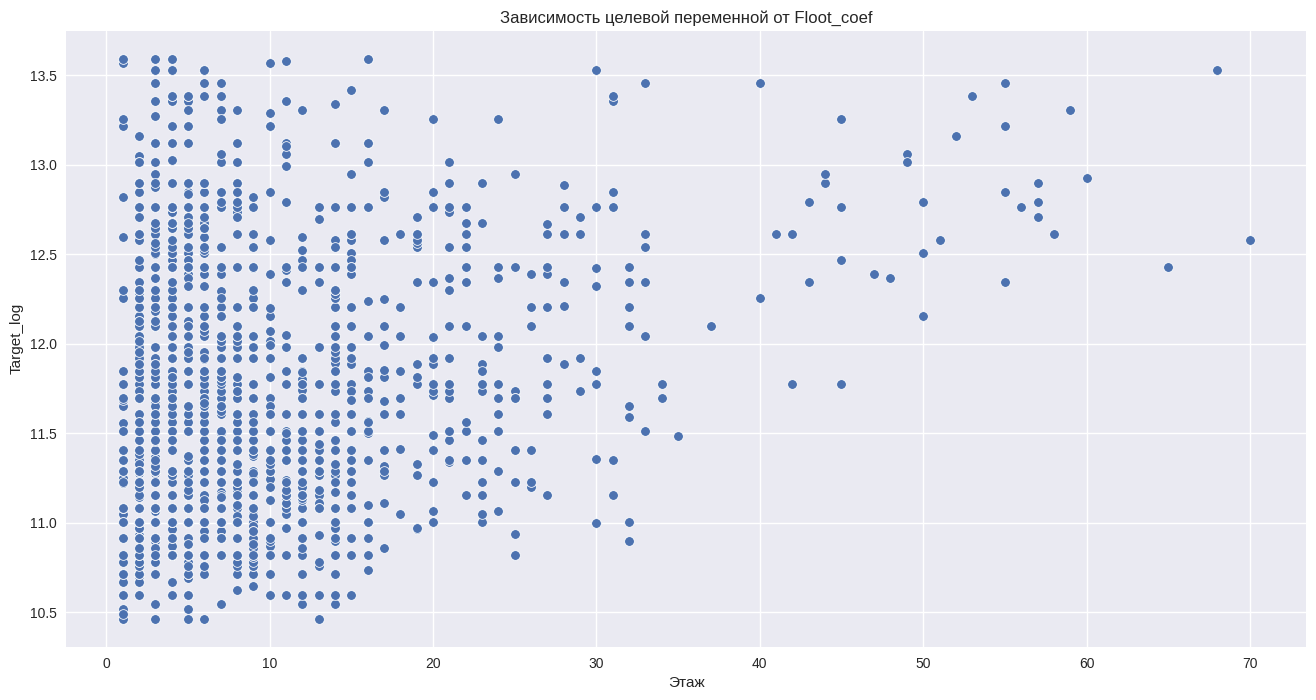

In [32]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))
sns.scatterplot(data=data, x='Этаж', y='Target_log', ax=ax)
ax.set_title('Зависимость целевой переменной от Floot_coef');

Видим, что в обоих случая присутствует корреляция, да слабая, но есть, при чем она является положительной.

### **Площадь**

Изучим зависимость целевой переменной от площади квартиры.

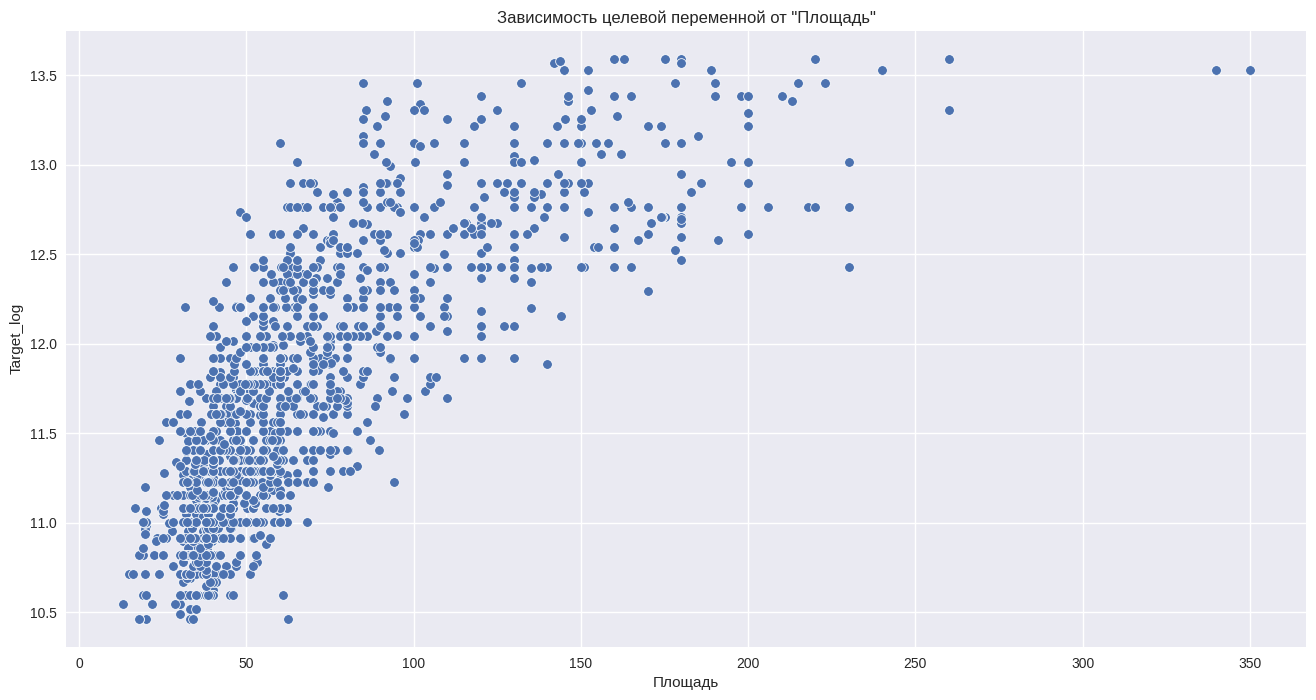

In [33]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))
sns.scatterplot(data, x='Площадь', y='Target_log', ax=ax)
ax.set_title('Зависимость целевой переменной от "Площадь"');

Видно, что признаки коррелируют друг с другом, при чем корреляция является не линейной, попробуем это исправить. Посмотрим на распределение признака.

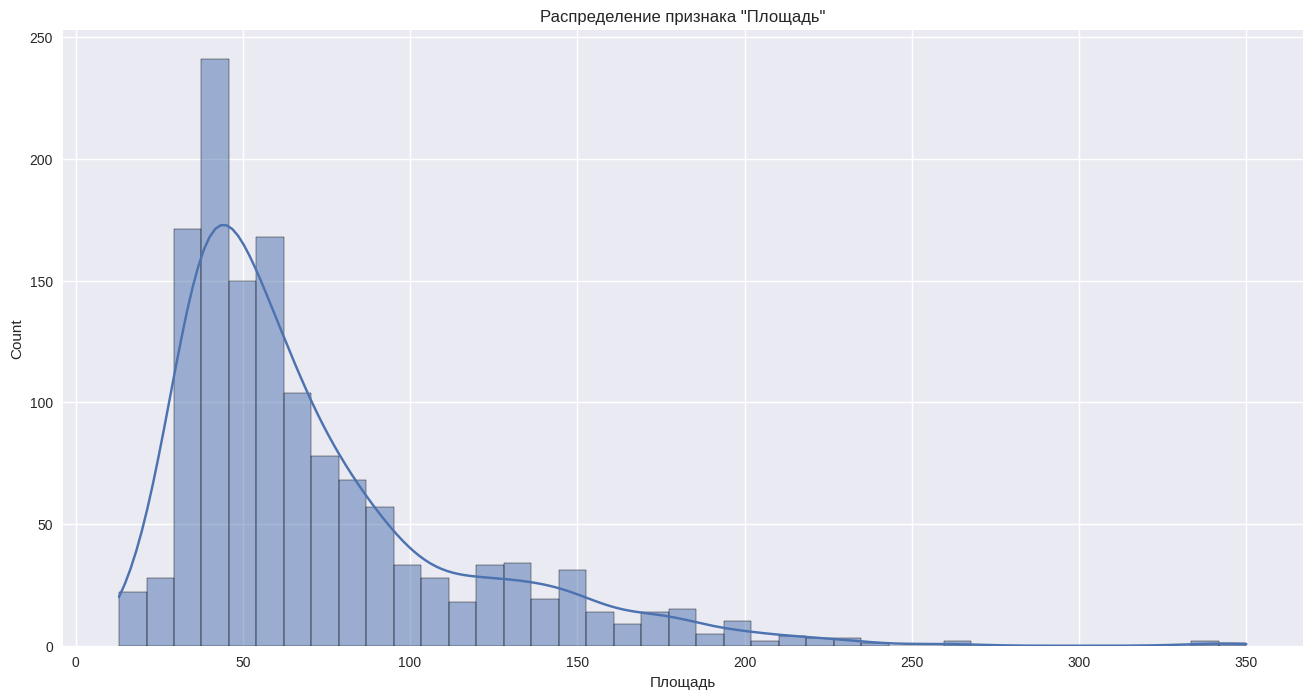

In [34]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))
sns.histplot(data, x='Площадь', kde=True, ax=ax)
ax.set_title('Распределение признака "Площадь"');

Распределение, как и у целевой переменной, имеет характер похожий на логарифмическое с длинным хвостом, попробуем преобразовать этот признак, сделав его более нормальным.

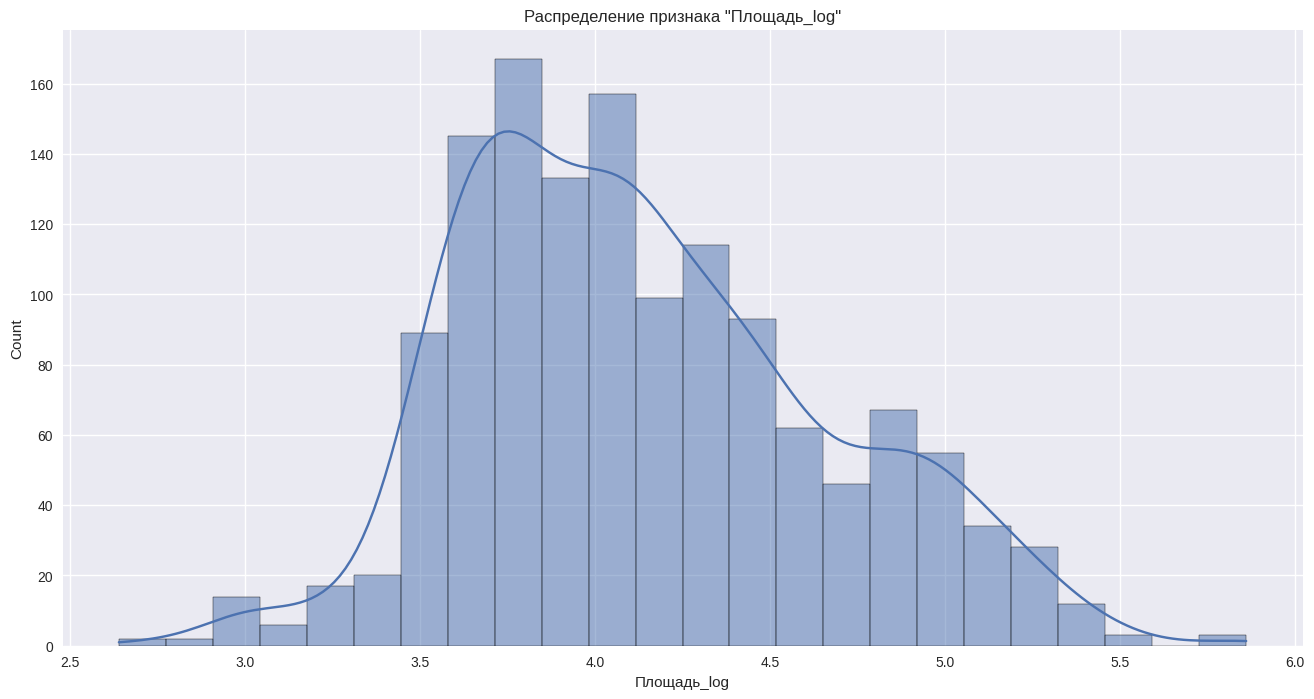

In [35]:
data['Площадь_log'] = data['Площадь'].apply(lambda x: np.log(1 + x))

fig, ax = plt.subplots(1, 1, figsize=(16, 8))
sns.histplot(data, x='Площадь_log', kde=True, ax=ax)
ax.set_title('Распределение признака "Площадь_log"');

Теперь распределение стало больше похоже на нормальное, удаляем исходный признак.

In [36]:
data = data.drop('Площадь', axis=1)
data.head()

,Этаж,Кол-во этажей,Жилая площадь,Площадь кухни,Кол-во комнат,Наличие мебели,Округ,"Ближайшее метро, мин.","Стоимость, мес.",Кол-во балконов,Продажа от агента,Кол-во грузовых лифтов,Кол-во пассажирских лифтов,Парковка,Target_log,Последний этаж,Первый этаж,Площадь_log
0,20,23,45.5,10.0,3,True,СЗАО,4.0,168800,0,True,1,1,underground,12.036476,0.0,0.0,4.330733
2,23,23,18.0,9.0,1,True,НАО (Новомосковский),2.0,60000,0,True,0,3,ground,11.002117,1.0,0.0,3.761200
3,8,10,72.0,16.0,3,True,ЦАО,3.0,400000,0,True,0,1,underground,12.899222,0.0,0.0,4.836282
4,45,75,120.0,40.0,3,True,ЦАО,3.0,570000,0,True,2,4,underground,13.253393,0.0,0.0,4.795791
5,15,19,40.0,10.0,1,True,НАО (Новомосковский),4.0,65000,0,False,1,1,ground,11.082158,0.0,0.0,3.713572


Посмотрим, как зависит таргет от преобразованной переменной.

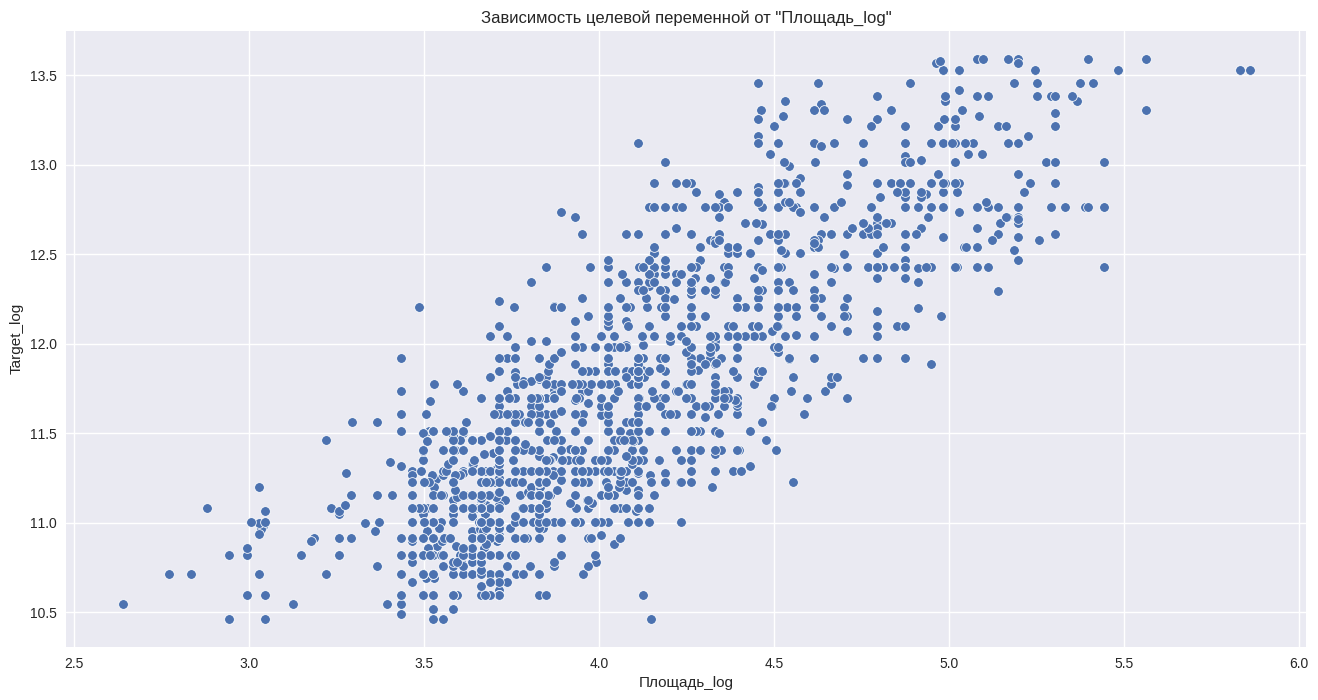

In [37]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))
sns.scatterplot(data, x='Площадь_log', y='Target_log', ax=ax)
ax.set_title('Зависимость целевой переменной от "Площадь_log"');

Теперь зависимость стала более простой.

### **Жилая площадь**

Также рассмотрим распределение признака.

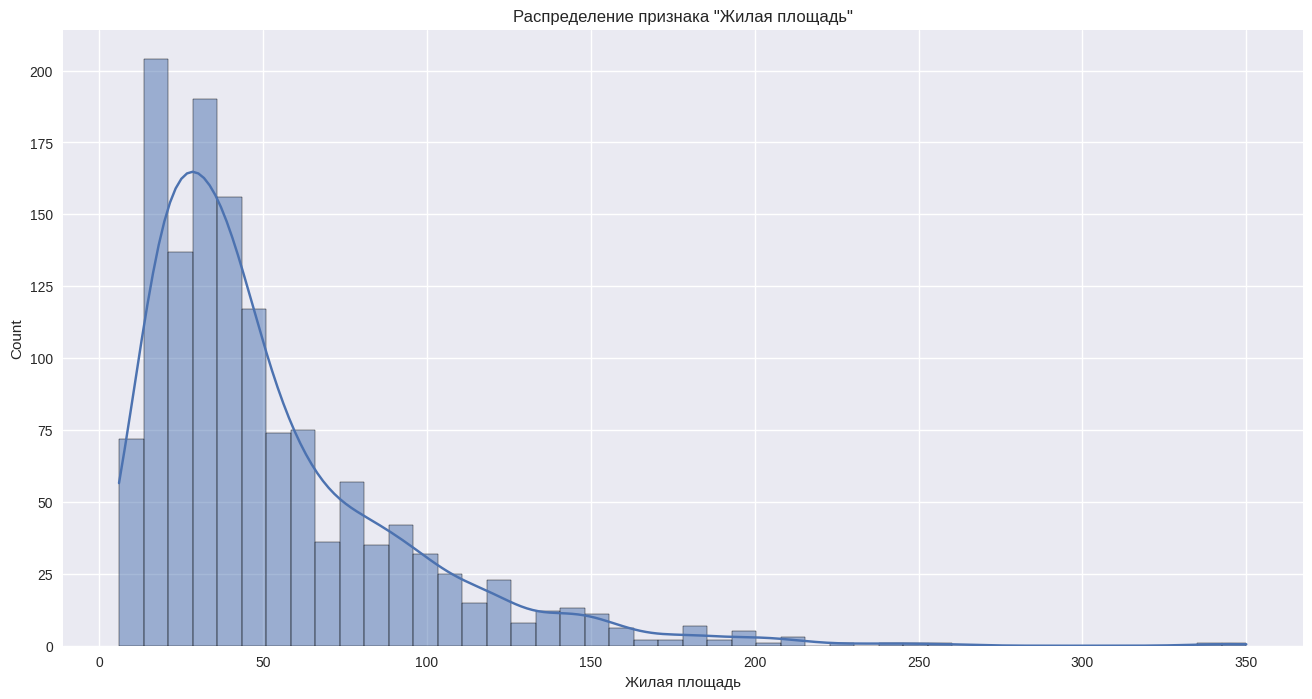

In [38]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))
sns.histplot(data, x='Жилая площадь', kde=True, ax=ax)
ax.set_title('Распределение признака "Жилая площадь"');

Посмотрим, как этот признак влияет на целевую переменную.

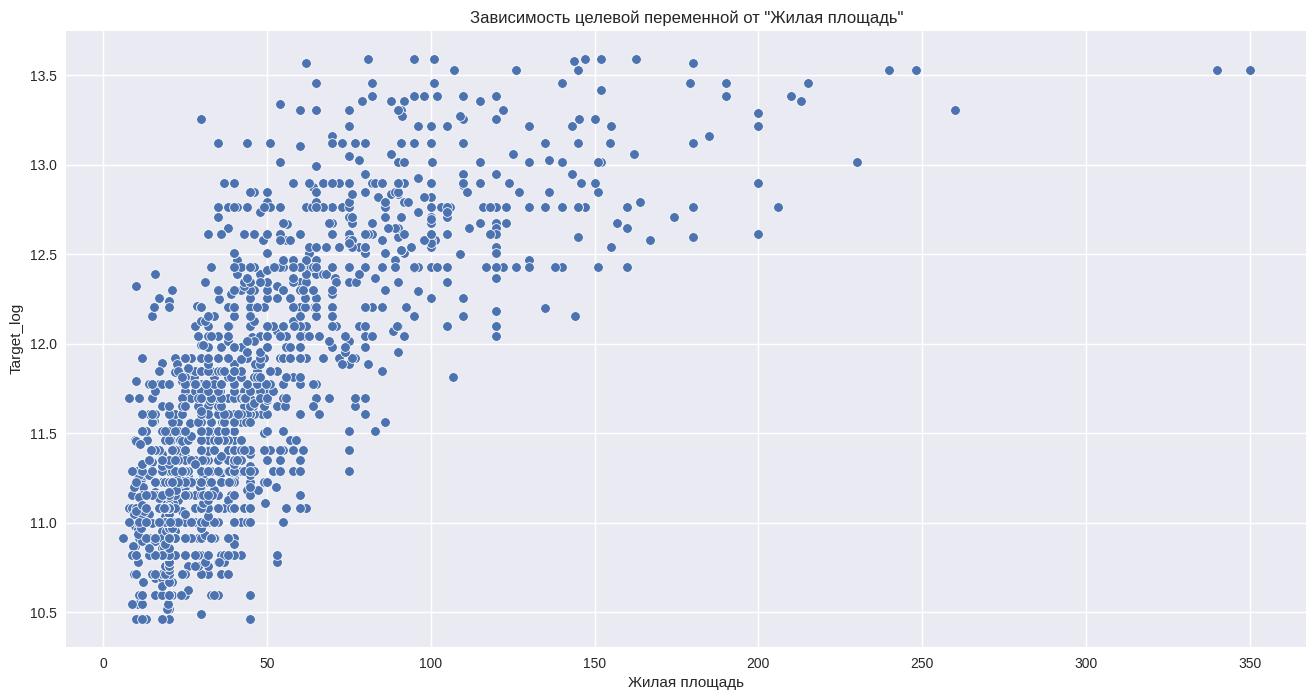

In [39]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))
sns.scatterplot(data, x='Жилая площадь', y='Target_log', ax=ax)
ax.set_title('Зависимость целевой переменной от "Жилая площадь"');

Поступим также, как с признакам площади квартиры.

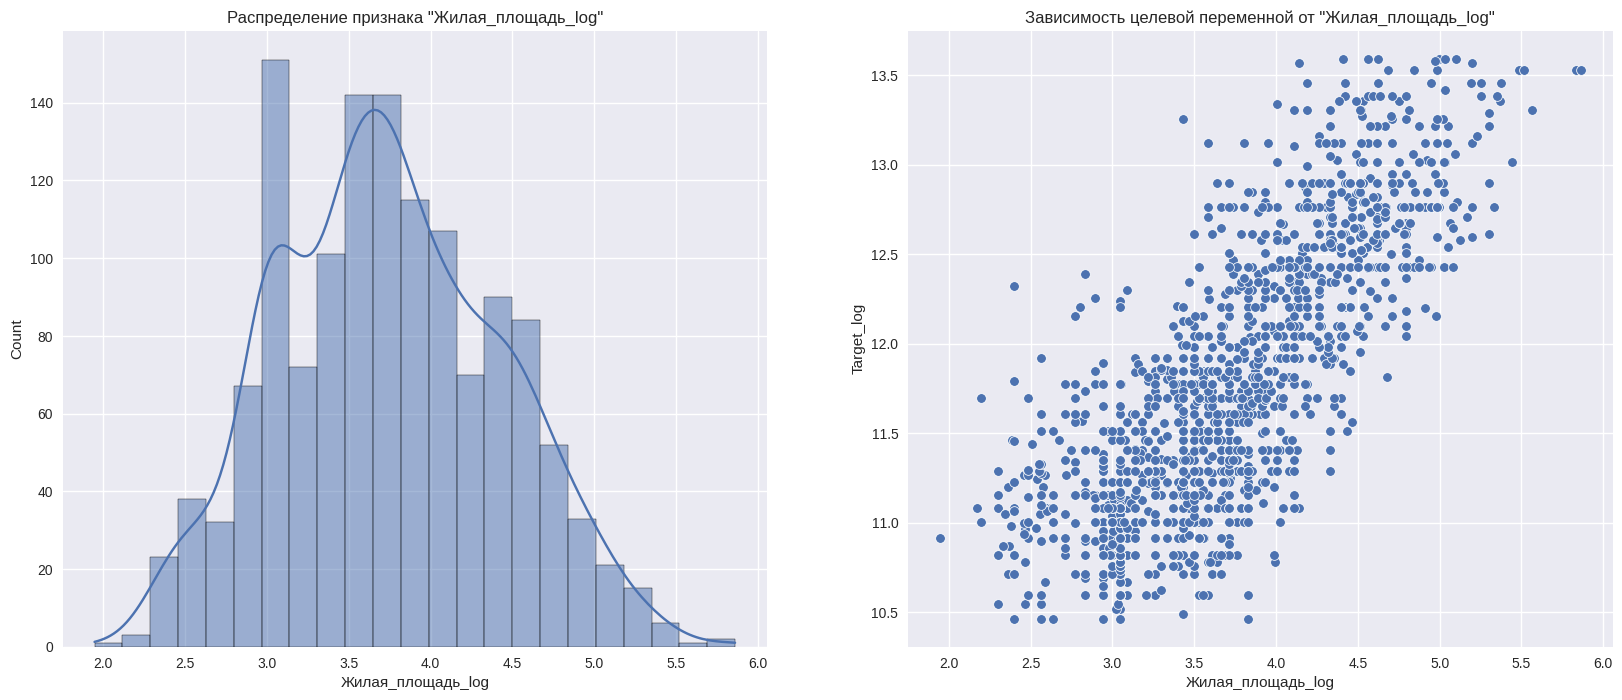

In [40]:
data['Жилая_площадь_log'] = data['Жилая площадь'].apply(lambda x: np.log(1 + x))
data = data.drop('Жилая площадь', axis=1)

fig, axes = plt.subplots(1, 2, figsize=(20, 8))
sns.histplot(data, x='Жилая_площадь_log', kde=True, ax=axes[0])
axes[0].set_title('Распределение признака "Жилая_площадь_log"')

sns.scatterplot(data, x='Жилая_площадь_log', y='Target_log', ax=axes[1])
axes[1].set_title('Зависимость целевой переменной от "Жилая_площадь_log"');

Распределение стало более нормальным, а зависимость более понятной.

### **Площадь кухни**

С этим признаком мы уже немного работали, заполняли в нем пропуски. Давайте снова посмотрим на его распределение, а также на зависимость целевой переменной.

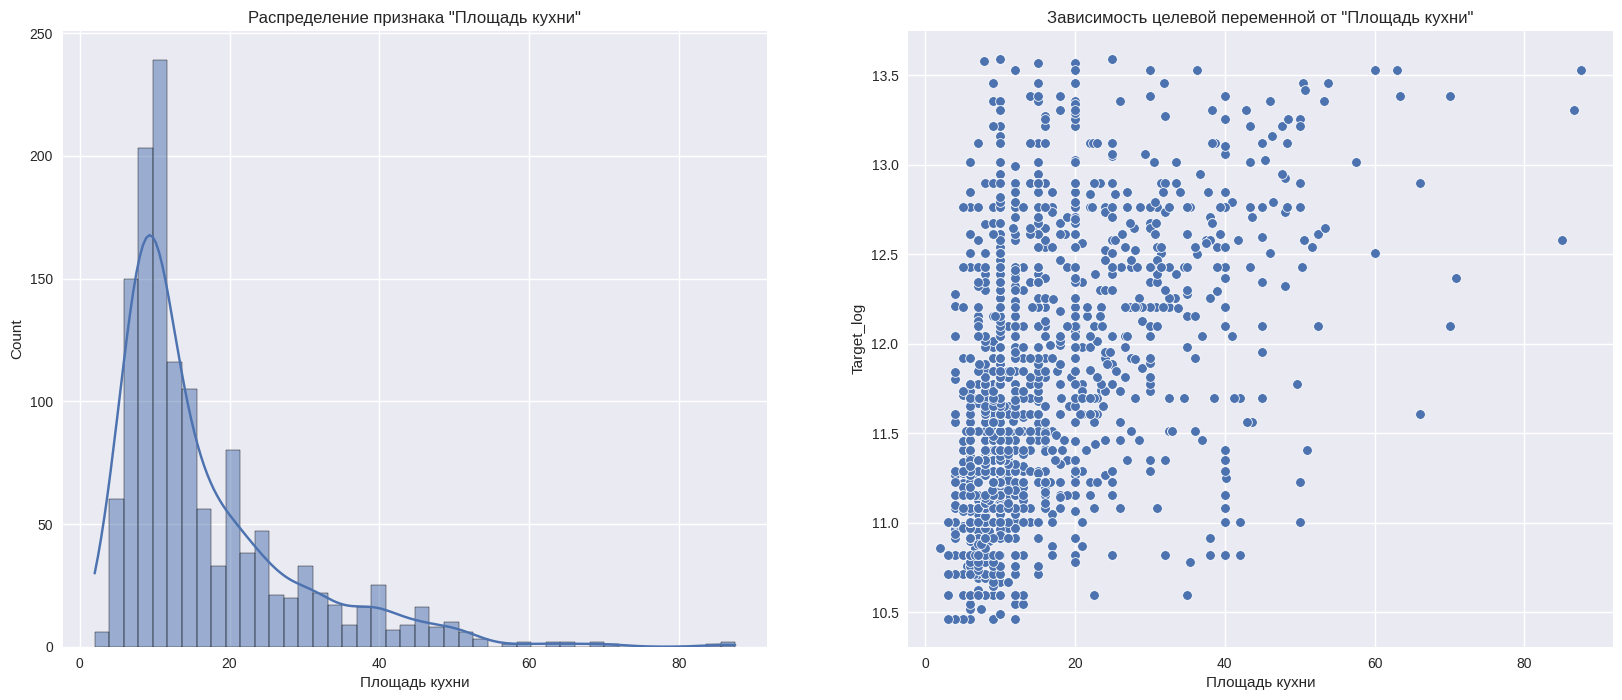

In [41]:
fig, axes = plt.subplots(1, 2, figsize=(20, 8))
sns.histplot(data, x='Площадь кухни', kde=True, ax=axes[0])
axes[0].set_title('Распределение признака "Площадь кухни"')

sns.scatterplot(data, x='Площадь кухни', y='Target_log', ax=axes[1])
axes[1].set_title('Зависимость целевой переменной от "Площадь кухни"');

Распределение имеет похожий характер на предыдущие признаки - это логично все три признакак по сути описывают одно и тоже явление. Корреляция с целевой переменной является более слабой, давайте попробуем повторить наш трюк.

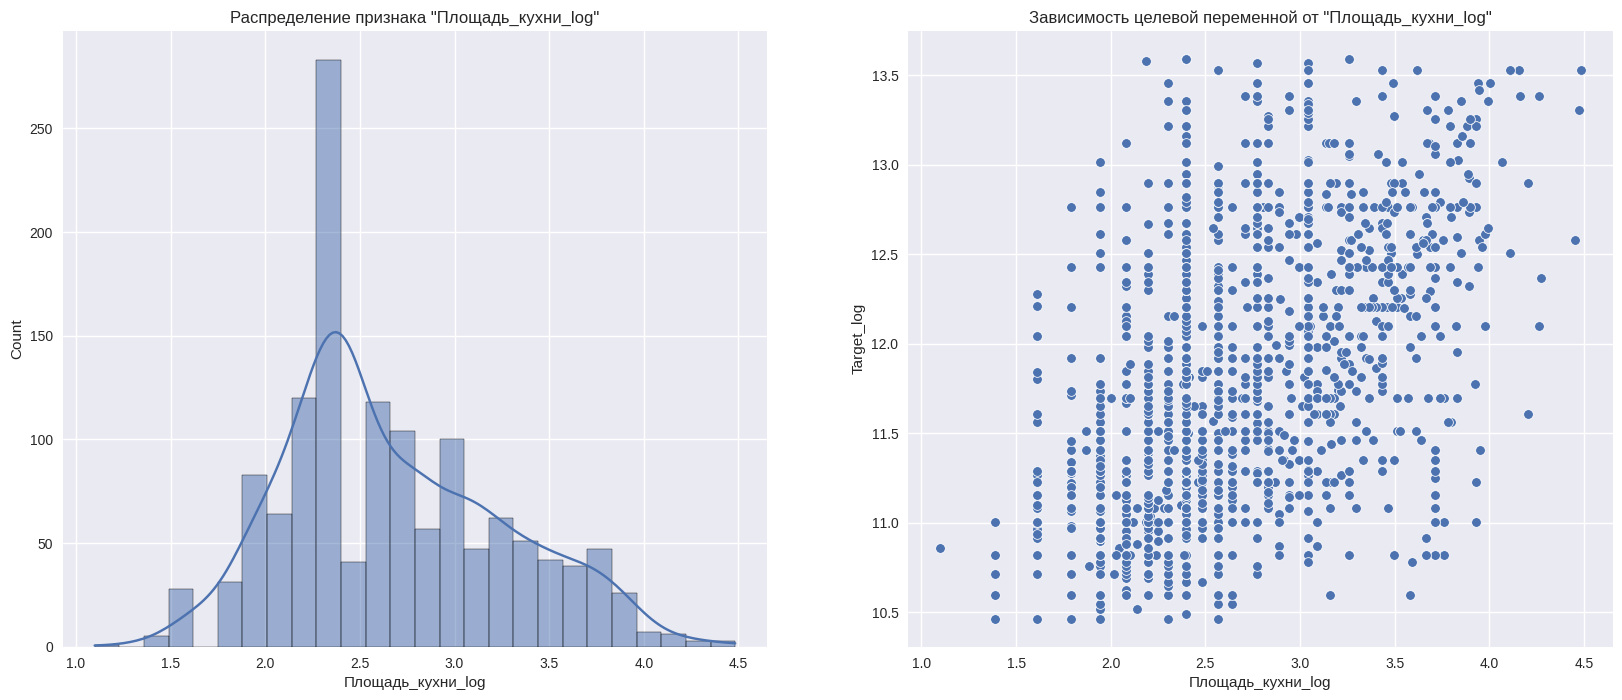

In [42]:
data['Площадь_кухни_log'] = data['Площадь кухни'].apply(lambda x: np.log(1 + x))

fig, axes = plt.subplots(1, 2, figsize=(20, 8))
sns.histplot(data, x='Площадь_кухни_log', kde=True, ax=axes[0])
axes[0].set_title('Распределение признака "Площадь_кухни_log"')

sns.scatterplot(data, x='Площадь_кухни_log', y='Target_log', ax=axes[1])
axes[1].set_title('Зависимость целевой переменной от "Площадь_кухни_log"');

Мне не нравится результат, давайте посмотрим на коэффициент корреляции исходного признака и преобразованного с целевой переменной, оставим тот, у которого она больше по модулю.

In [43]:
data[['Площадь кухни', 'Площадь_кухни_log', 'Target_log']].corr()

,Площадь кухни,Площадь_кухни_log,Target_log
Площадь кухни,1.000000,0.942167,0.454158
Площадь_кухни_log,0.942167,1.000000,0.495705
Target_log,0.454158,0.495705,1.000000


У преобразованного признака корреляция больше, оставляем его.

In [44]:
data = data.drop('Площадь кухни', axis=1)
data.head()

,Этаж,Кол-во этажей,Кол-во комнат,Наличие мебели,Округ,"Ближайшее метро, мин.","Стоимость, мес.",Кол-во балконов,Продажа от агента,Кол-во грузовых лифтов,Кол-во пассажирских лифтов,Парковка,Target_log,Последний этаж,Первый этаж,Площадь_log,Жилая_площадь_log,Площадь_кухни_log
0,20,23,3,True,СЗАО,4.0,168800,0,True,1,1,underground,12.036476,0.0,0.0,4.330733,3.839452,2.397895
2,23,23,1,True,НАО (Новомосковский),2.0,60000,0,True,0,3,ground,11.002117,1.0,0.0,3.761200,2.944439,2.302585
3,8,10,3,True,ЦАО,3.0,400000,0,True,0,1,underground,12.899222,0.0,0.0,4.836282,4.290459,2.833213
4,45,75,3,True,ЦАО,3.0,570000,0,True,2,4,underground,13.253393,0.0,0.0,4.795791,4.795791,3.713572
5,15,19,1,True,НАО (Новомосковский),4.0,65000,0,False,1,1,ground,11.082158,0.0,0.0,3.713572,3.713572,2.397895


### **Кол-во комнат**

Распределение признака:

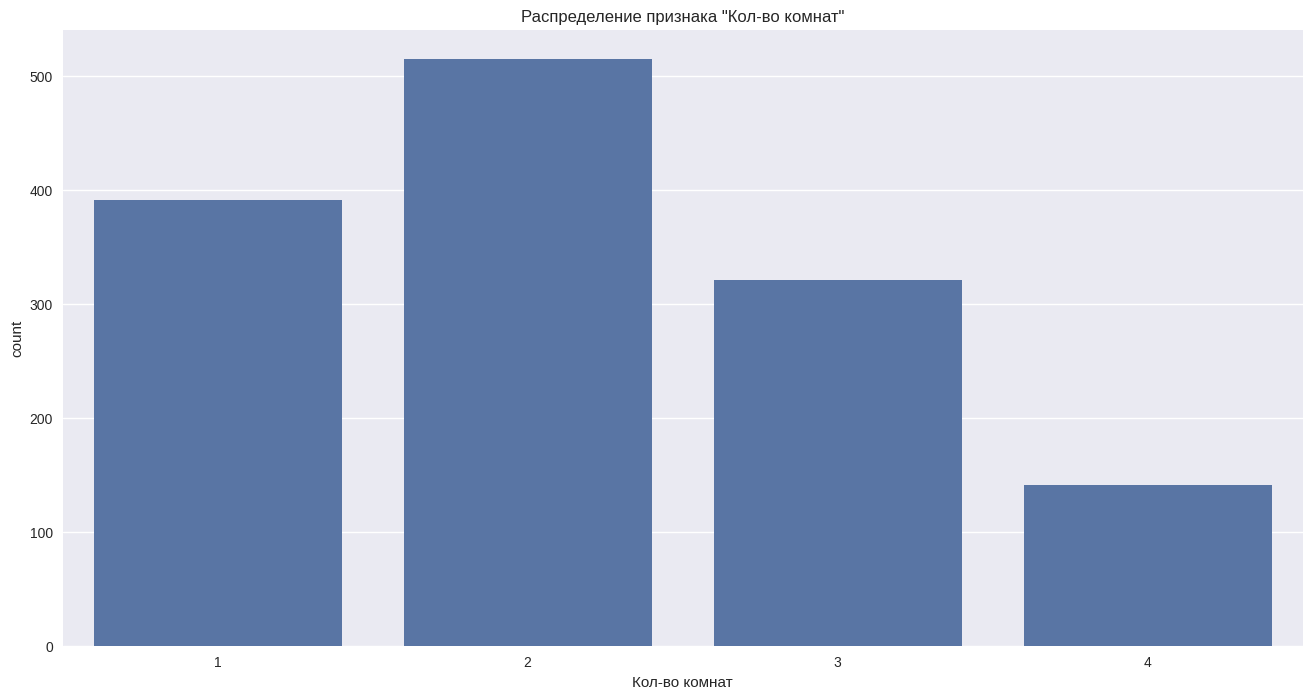

In [45]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))
sns.countplot(data, x='Кол-во комнат', ax=ax)
ax.set_title('Распределение признака "Кол-во комнат"');

Преобладают 2-х комнатные квартиры, меньше всего 4-х комнатных квартир. Давайте посмотрим на уелевую переменную в разрезе этого признака.

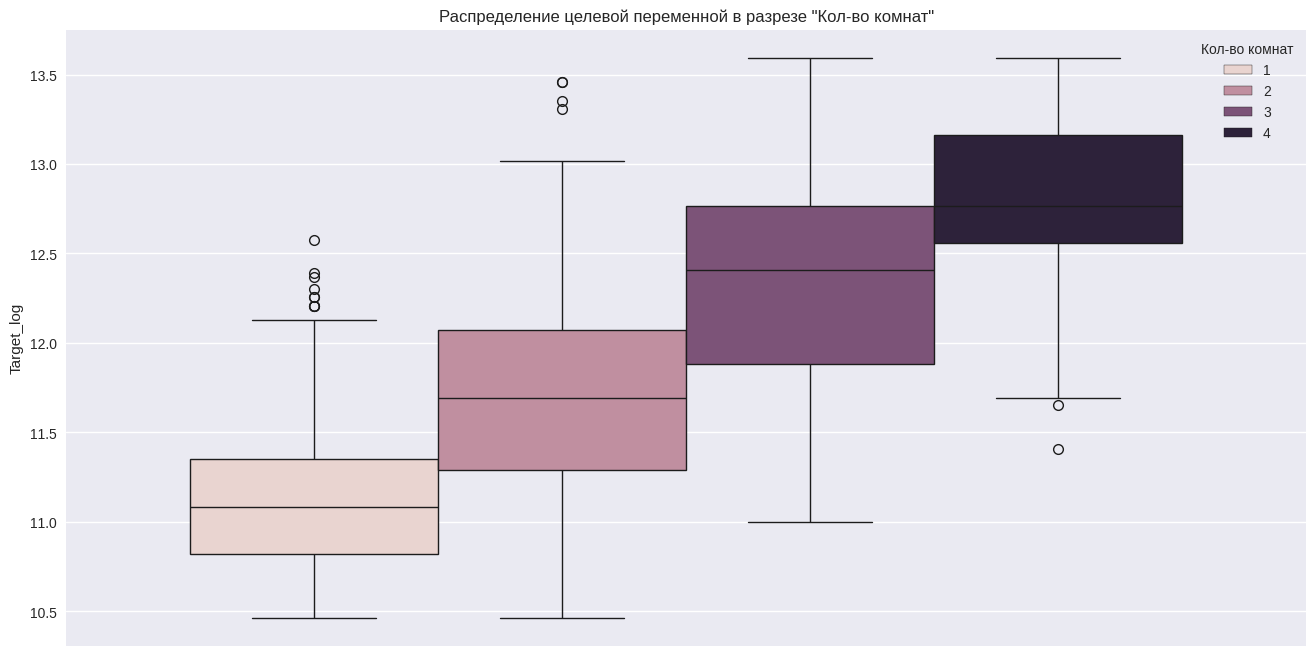

In [46]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))
sns.boxplot(data, y='Target_log', hue='Кол-во комнат', ax=ax)
ax.set_title('Распределение целевой переменной в разрезе "Кол-во комнат"');

Здесь четко прослеживается зависимость, чем больше комнат, тем больше стоимость.

### **Наличие мебели**

Посмотрим на классы этого признака в разрезе кол-ва комнат:

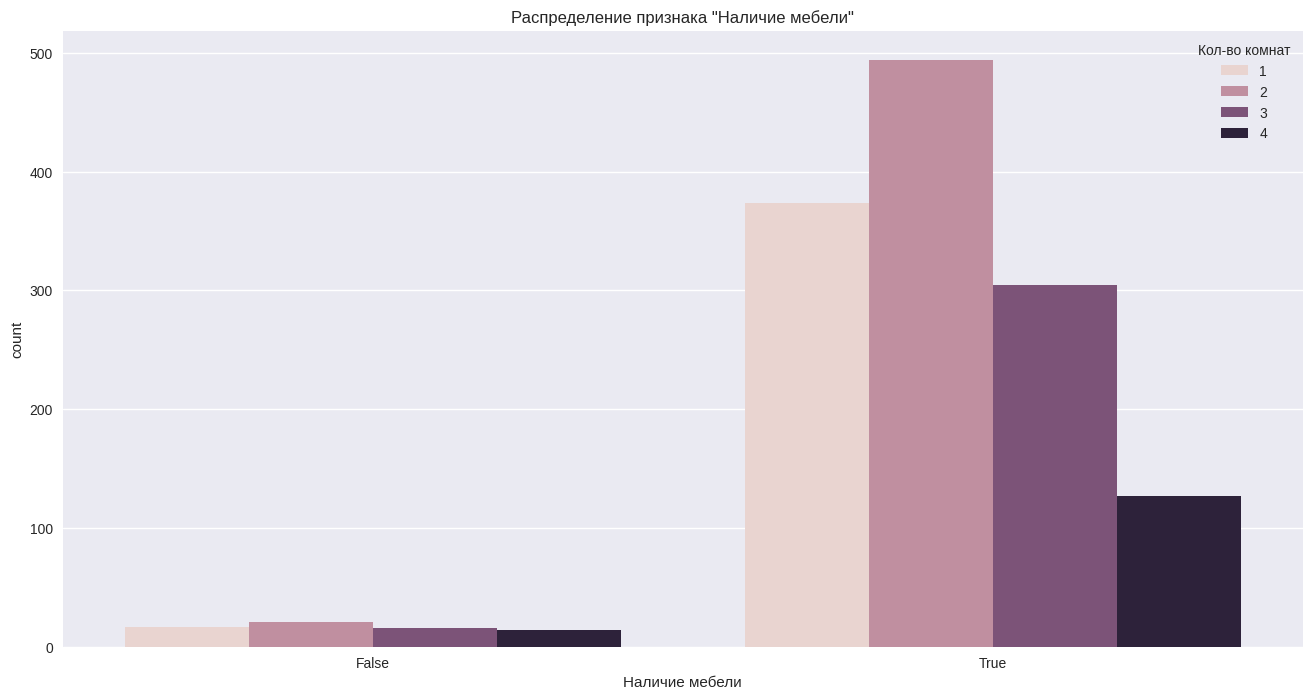

In [47]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))
sns.countplot(data, x='Наличие мебели', hue='Кол-во комнат', ax=ax)
ax.set_title('Распределение признака "Наличие мебели"');

Очень сильный дисбаланс классов, посмотрим на то, как ведет себя целевая переменная в зависимости от этого признака в разрезе кол-ва комнат.

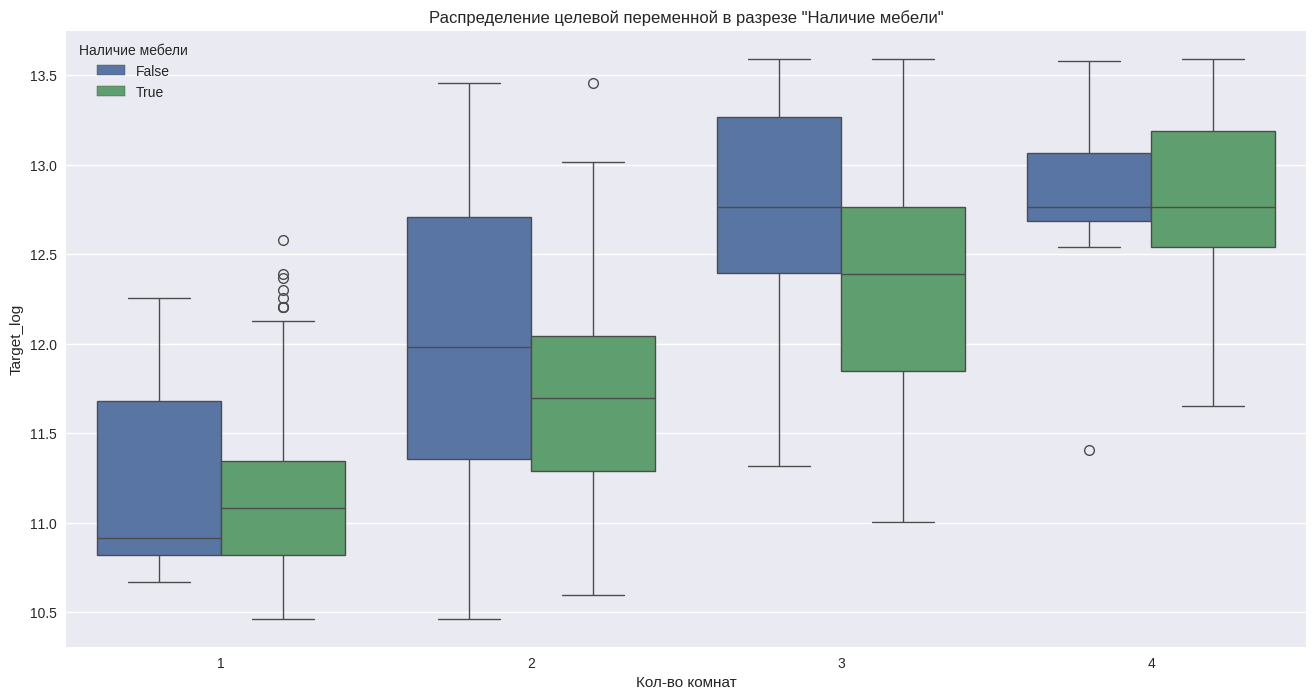

In [48]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))
sns.boxplot(data, y='Target_log', x='Кол-во комнат', hue='Наличие мебели', ax=ax)
ax.set_title('Распределение целевой переменной в разрезе "Наличие мебели"');

В некоторых случаях квартиры без мебели стоят дороже, чем с мебелью, это может быть связано с тем, что в новых квартирах мебель еще не завезли, а также с тем, что кол-во наблюдений без мебели слишком мало и это искажает общую статистику.

### **Округ**

Посмотрим, какие округи есть:

In [49]:
data['Округ'].unique().tolist()

['СЗАО',
 'НАО (Новомосковский)',
 'ЦАО',
 'ЗАО',
 'САО',
 'ЮАО',
 'СВАО',
 'ЮЗАО',
 'ЗелАО',
 'ЮВАО',
 'ВАО']

Округи соответсвуеют действительности, посмотрим на распределение.

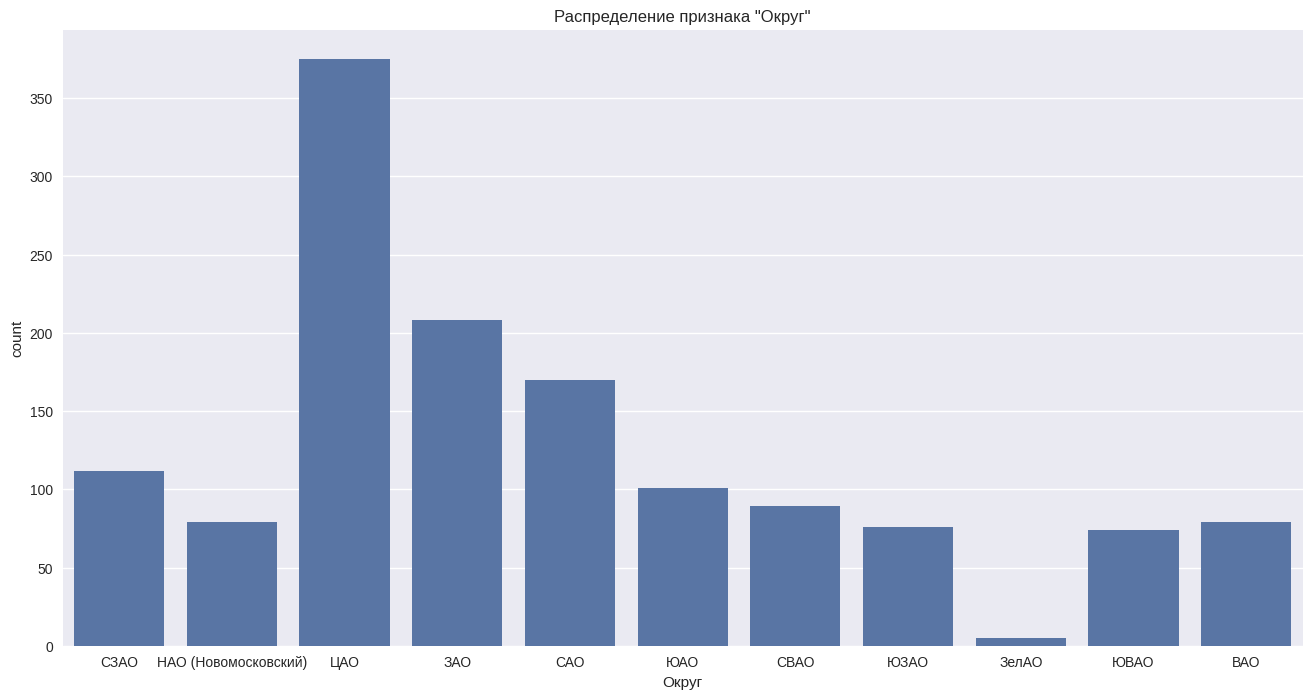

In [50]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))
sns.countplot(data, x='Округ', ax=ax)
ax.set_title('Распределение признака "Округ"');

Посмотрим на наш таргет в разрезе этого признака.

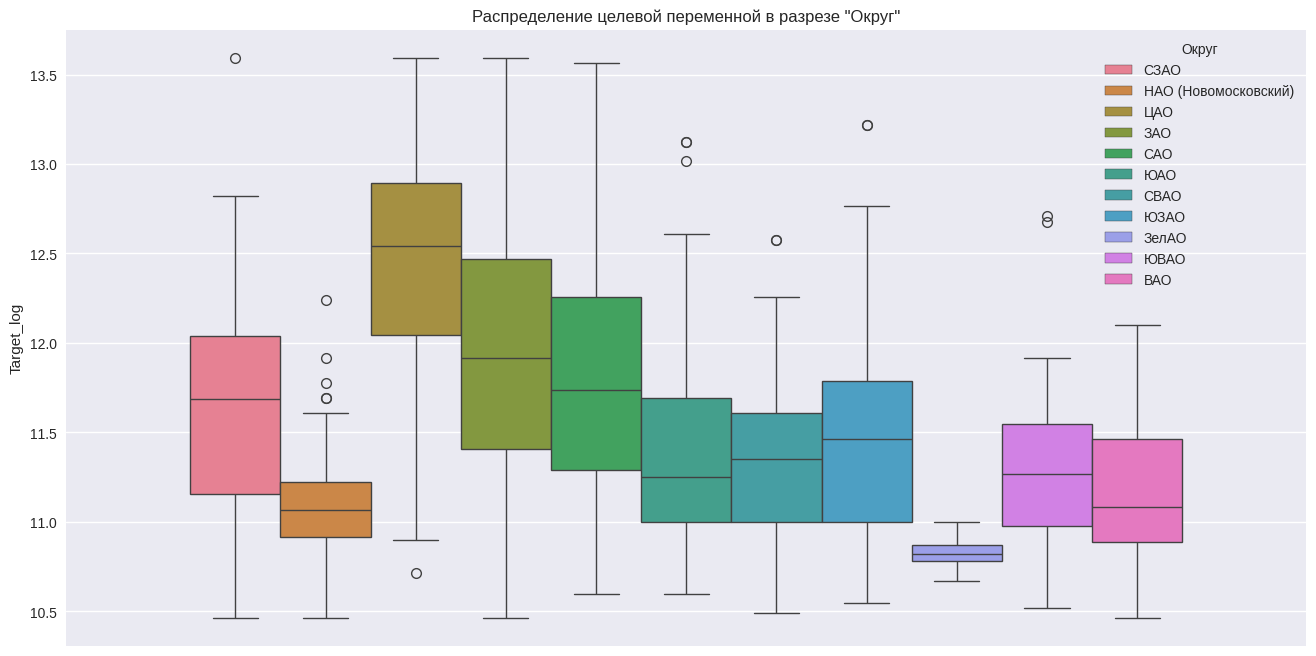

In [51]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))
sns.boxplot(data, y='Target_log', hue='Округ', ax=ax)
ax.set_title('Распределение целевой переменной в разрезе "Округ"');

Заметим, что выделяются следующие округи: ЦАО, НАО, ЗАО и САО, остальные имеют схожую цену, давайте объеденим их в один.

In [52]:
def preprocessing_okrug(x):
    if x in ['СЗАО', 'ЮАО', 'СВАО', 'ЮЗАО', 'ЗелАО', 'ЮВАО', 'ВАО']:
        return 'other'
    else:
        return x

data['Округ'] = data['Округ'].apply(lambda x: preprocessing_okrug(x))
data['Округ'].unique()

array(['other', 'НАО (Новомосковский)', 'ЦАО', 'ЗАО', 'САО'], dtype=object)

Таргет для преобразованного признака:

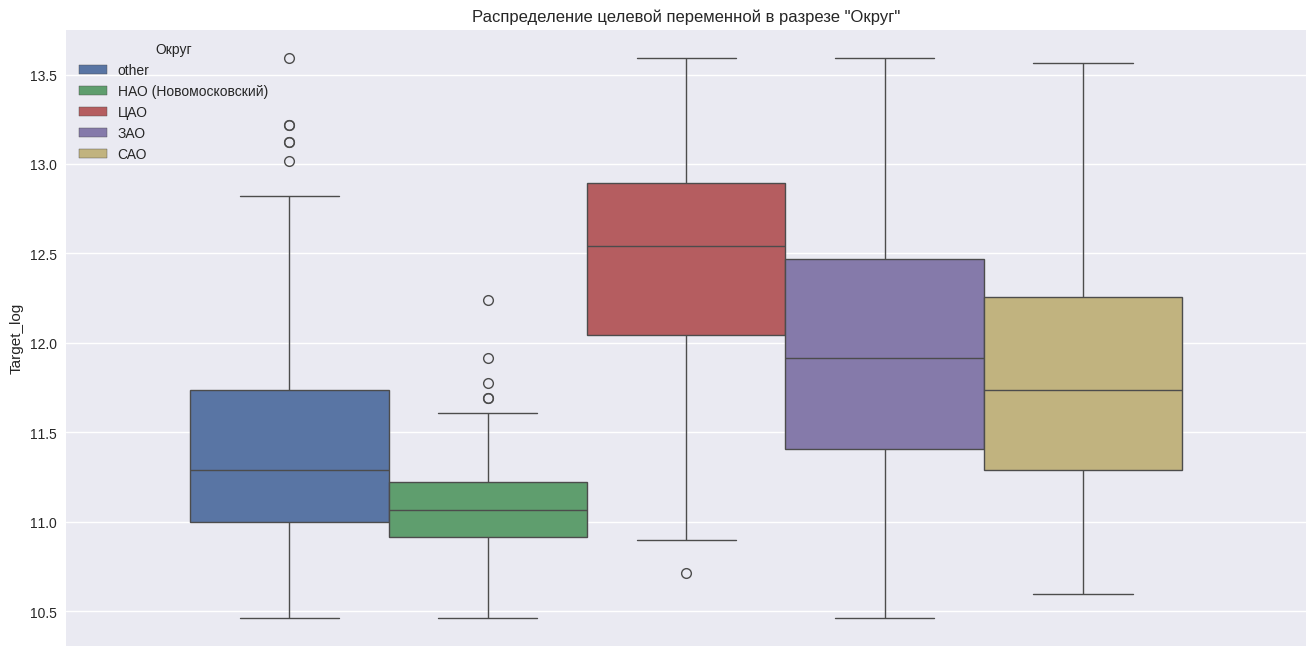

In [53]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))
sns.boxplot(data, y='Target_log', hue='Округ', ax=ax)
ax.set_title('Распределение целевой переменной в разрезе "Округ"');

###  **Кол-во балконов**

Распределение:

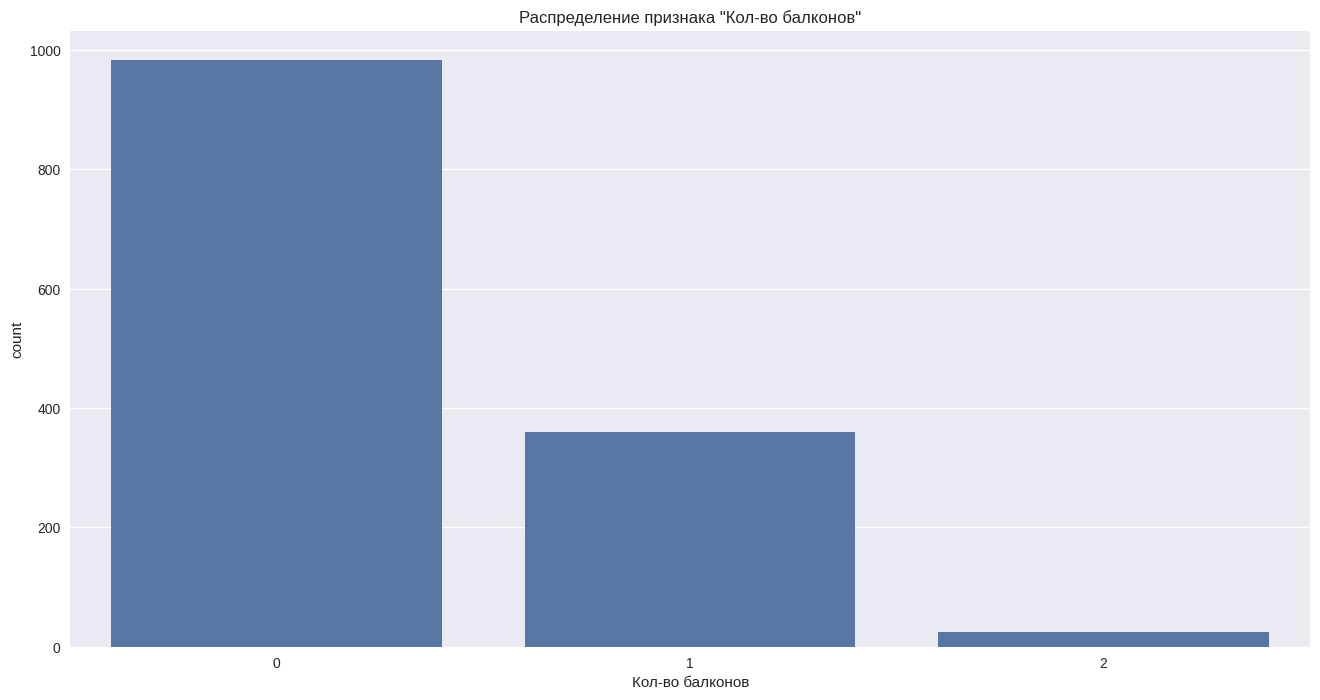

In [54]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))
sns.countplot(data, x='Кол-во балконов', ax=ax)
ax.set_title('Распределение признака "Кол-во балконов"');

Видим, что в классах присутствует дисбаланс, поэтому создадим новый признак "Наличие балкона" - 1 если есть, 0 - если отсутствует.

In [55]:
data['Наличие балкона'] = data['Кол-во балконов'].apply(lambda x: 0 if x == 0 else 1)
data = data.drop('Кол-во балконов', axis=1)
data.head()

,Этаж,Кол-во этажей,Кол-во комнат,Наличие мебели,Округ,"Ближайшее метро, мин.","Стоимость, мес.",Продажа от агента,Кол-во грузовых лифтов,Кол-во пассажирских лифтов,Парковка,Target_log,Последний этаж,Первый этаж,Площадь_log,Жилая_площадь_log,Площадь_кухни_log,Наличие балкона
0,20,23,3,True,other,4.0,168800,True,1,1,underground,12.036476,0.0,0.0,4.330733,3.839452,2.397895,0
2,23,23,1,True,НАО (Новомосковский),2.0,60000,True,0,3,ground,11.002117,1.0,0.0,3.761200,2.944439,2.302585,0
3,8,10,3,True,ЦАО,3.0,400000,True,0,1,underground,12.899222,0.0,0.0,4.836282,4.290459,2.833213,0
4,45,75,3,True,ЦАО,3.0,570000,True,2,4,underground,13.253393,0.0,0.0,4.795791,4.795791,3.713572,0
5,15,19,1,True,НАО (Новомосковский),4.0,65000,False,1,1,ground,11.082158,0.0,0.0,3.713572,3.713572,2.397895,0


Распределение нового признака:

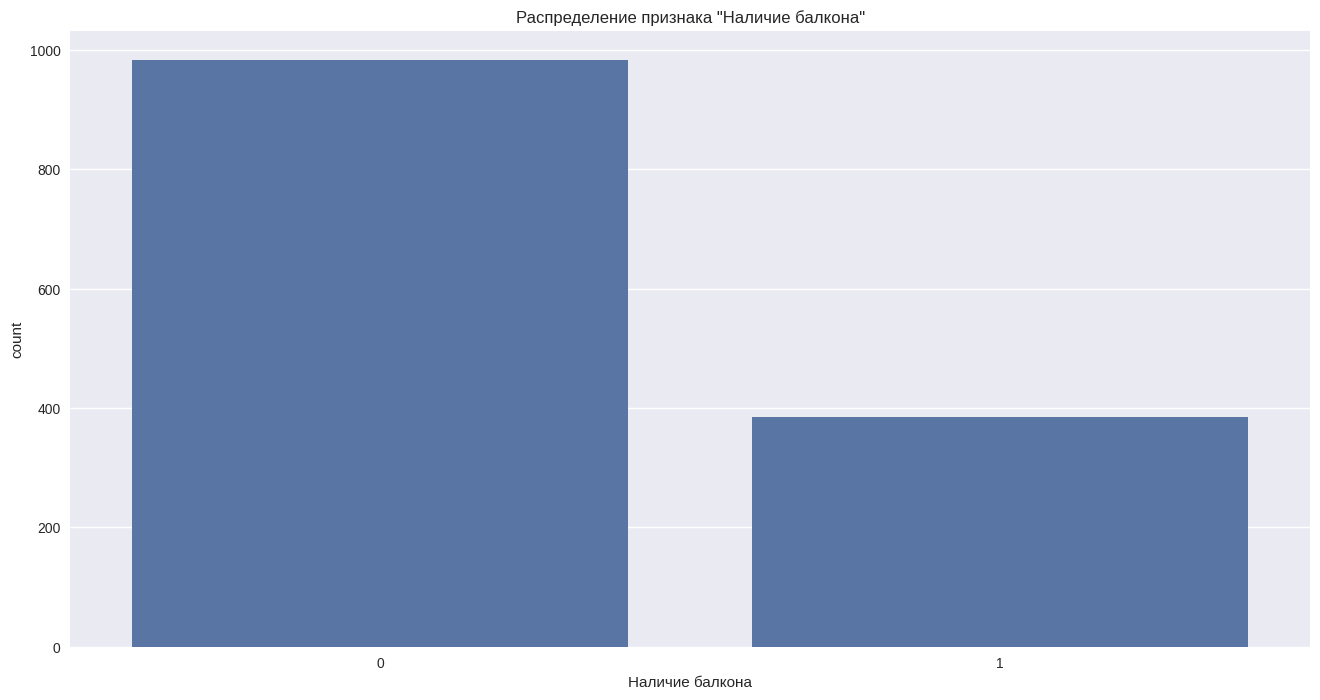

In [56]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))
sns.countplot(data, x='Наличие балкона', ax=ax)
ax.set_title('Распределение признака "Наличие балкона"');

Таргет в разрезе нового признака:

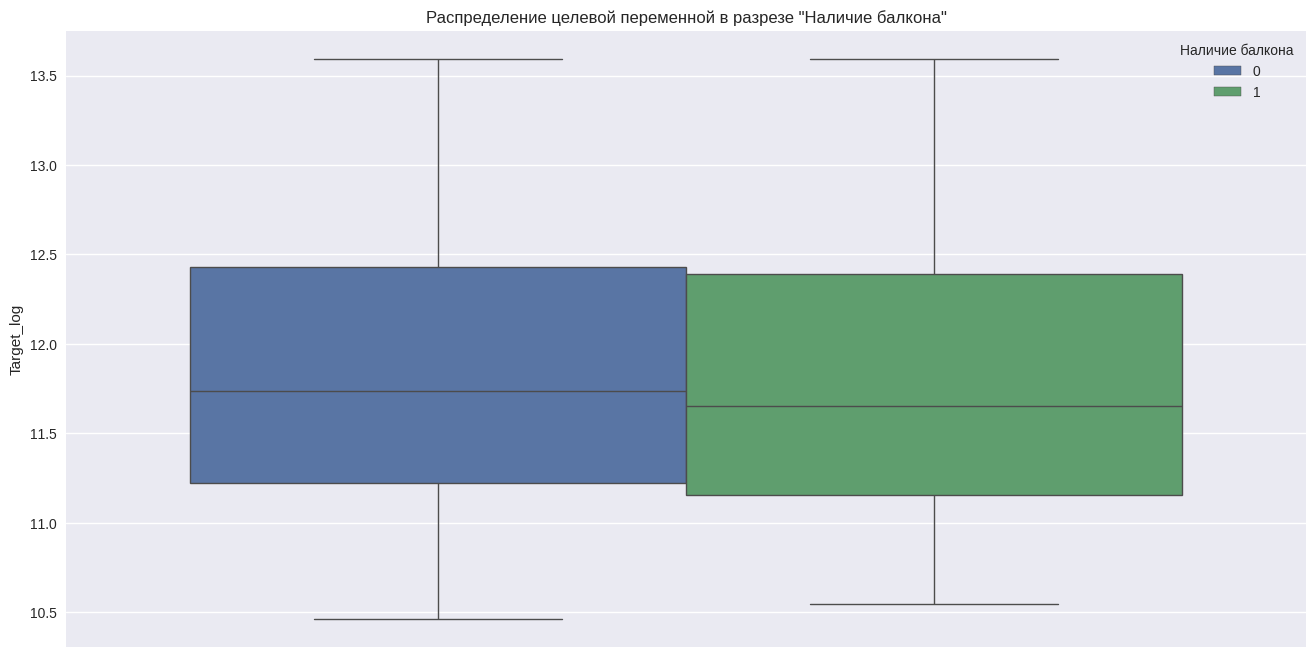

In [57]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))
sns.boxplot(data, y='Target_log', hue='Наличие балкона', ax=ax)
ax.set_title('Распределение целевой переменной в разрезе "Наличие балкона"');

Цены на квартиры с балконом и без почти не отличаются.

### **Продажа от агента**

Распределение признака:

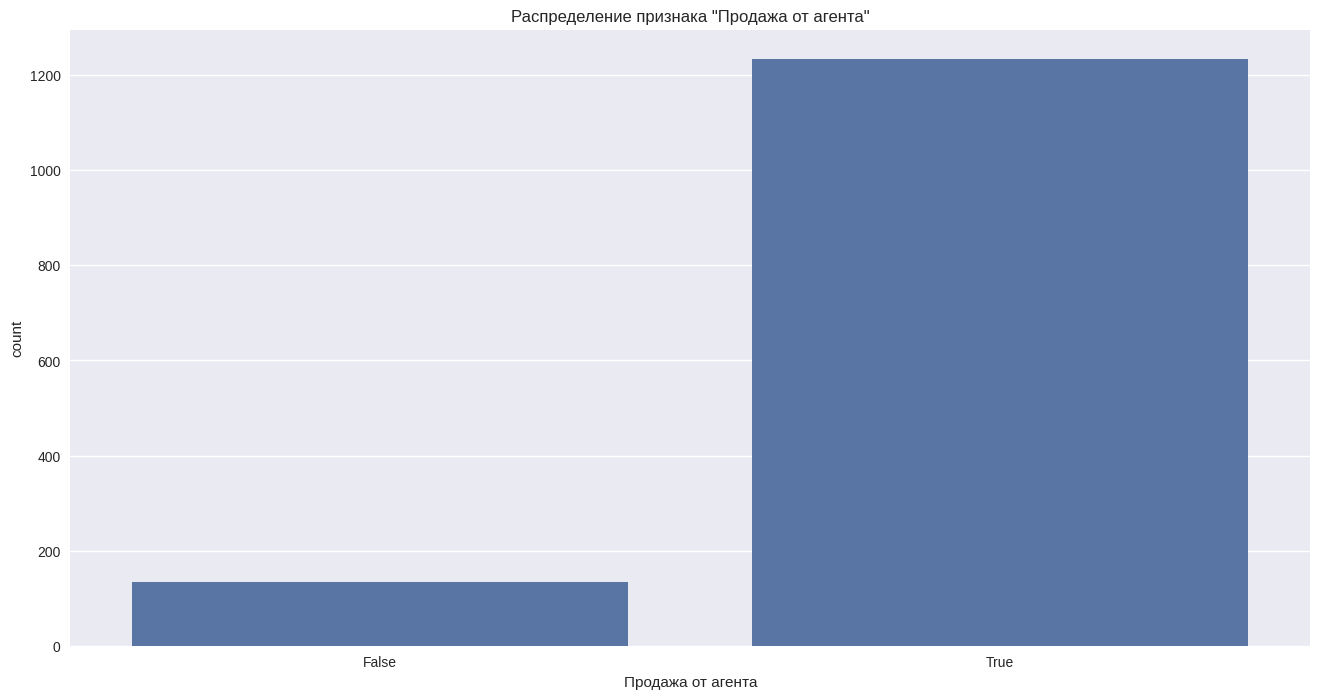

In [58]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))
sns.countplot(data, x='Продажа от агента', ax=ax)
ax.set_title('Распределение признака "Продажа от агента"');

Таргет в разрезе признака:

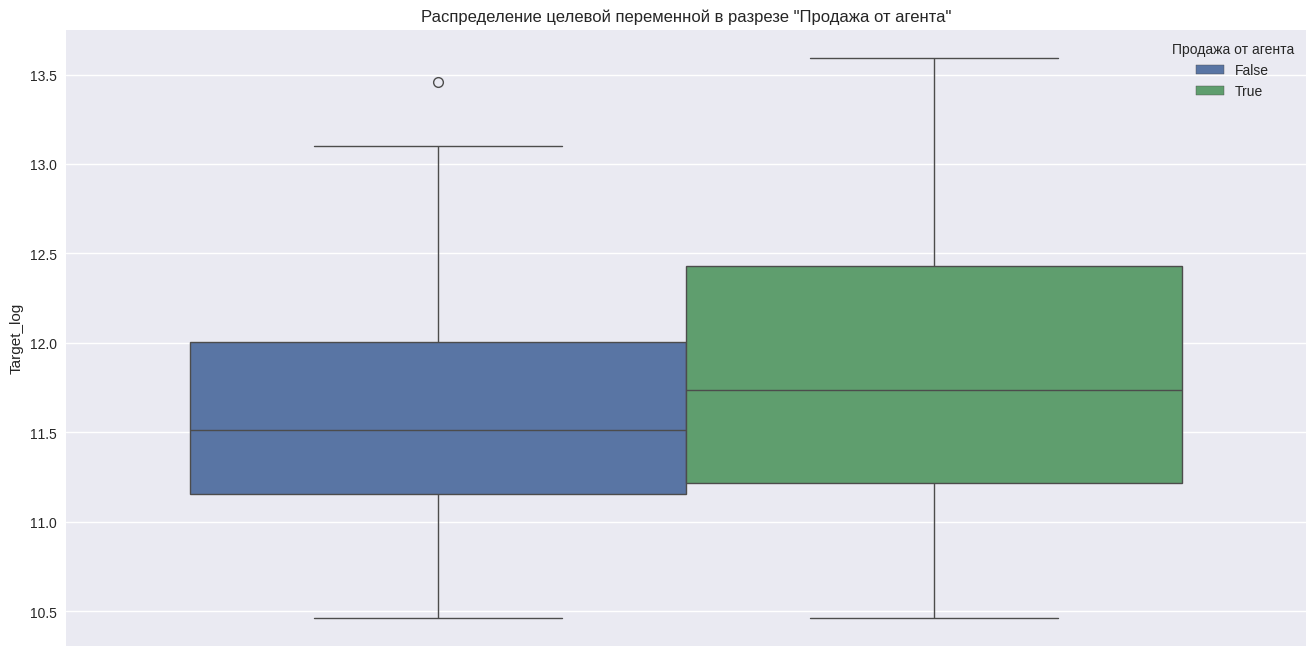

In [59]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))
sns.boxplot(data, y='Target_log', hue='Продажа от агента', ax=ax)
ax.set_title('Распределение целевой переменной в разрезе "Продажа от агента"');

Квартиры от собственников немного дешевле, чем при продаже от агентов.

### **Кол-во грузовых и пассажирских лифтов**

Для начала создадим новый признак "Кол-во лифтов".

In [60]:
data['Кол-во лифтов'] = data['Кол-во грузовых лифтов'] + data['Кол-во пассажирских лифтов']
data.head()

,Этаж,Кол-во этажей,Кол-во комнат,Наличие мебели,Округ,"Ближайшее метро, мин.","Стоимость, мес.",Продажа от агента,Кол-во грузовых лифтов,Кол-во пассажирских лифтов,Парковка,Target_log,Последний этаж,Первый этаж,Площадь_log,Жилая_площадь_log,Площадь_кухни_log,Наличие балкона,Кол-во лифтов
0,20,23,3,True,other,4.0,168800,True,1,1,underground,12.036476,0.0,0.0,4.330733,3.839452,2.397895,0,2
2,23,23,1,True,НАО (Новомосковский),2.0,60000,True,0,3,ground,11.002117,1.0,0.0,3.761200,2.944439,2.302585,0,3
3,8,10,3,True,ЦАО,3.0,400000,True,0,1,underground,12.899222,0.0,0.0,4.836282,4.290459,2.833213,0,1
4,45,75,3,True,ЦАО,3.0,570000,True,2,4,underground,13.253393,0.0,0.0,4.795791,4.795791,3.713572,0,6
5,15,19,1,True,НАО (Новомосковский),4.0,65000,False,1,1,ground,11.082158,0.0,0.0,3.713572,3.713572,2.397895,0,2


Также создадим признак "Наличие грузового лифта".

In [61]:
data['Наличие грузового лифта'] = data['Кол-во грузовых лифтов'].apply(lambda x: 0 if x == 0 else 1)
data.head()

,Этаж,Кол-во этажей,Кол-во комнат,Наличие мебели,Округ,"Ближайшее метро, мин.","Стоимость, мес.",Продажа от агента,Кол-во грузовых лифтов,Кол-во пассажирских лифтов,Парковка,Target_log,Последний этаж,Первый этаж,Площадь_log,Жилая_площадь_log,Площадь_кухни_log,Наличие балкона,Кол-во лифтов,Наличие грузового лифта
0,20,23,3,True,other,4.0,168800,True,1,1,underground,12.036476,0.0,0.0,4.330733,3.839452,2.397895,0,2,1
2,23,23,1,True,НАО (Новомосковский),2.0,60000,True,0,3,ground,11.002117,1.0,0.0,3.761200,2.944439,2.302585,0,3,0
3,8,10,3,True,ЦАО,3.0,400000,True,0,1,underground,12.899222,0.0,0.0,4.836282,4.290459,2.833213,0,1,0
4,45,75,3,True,ЦАО,3.0,570000,True,2,4,underground,13.253393,0.0,0.0,4.795791,4.795791,3.713572,0,6,1
5,15,19,1,True,НАО (Новомосковский),4.0,65000,False,1,1,ground,11.082158,0.0,0.0,3.713572,3.713572,2.397895,0,2,1


Удаляем теперь ненужные признаки: "Кол-во грузовых лифтов" и "Кол-во пассажирских лифтов".

In [62]:
data = data.drop(['Кол-во грузовых лифтов', 'Кол-во пассажирских лифтов'], axis=1)
data.head()

,Этаж,Кол-во этажей,Кол-во комнат,Наличие мебели,Округ,"Ближайшее метро, мин.","Стоимость, мес.",Продажа от агента,Парковка,Target_log,Последний этаж,Первый этаж,Площадь_log,Жилая_площадь_log,Площадь_кухни_log,Наличие балкона,Кол-во лифтов,Наличие грузового лифта
0,20,23,3,True,other,4.0,168800,True,underground,12.036476,0.0,0.0,4.330733,3.839452,2.397895,0,2,1
2,23,23,1,True,НАО (Новомосковский),2.0,60000,True,ground,11.002117,1.0,0.0,3.761200,2.944439,2.302585,0,3,0
3,8,10,3,True,ЦАО,3.0,400000,True,underground,12.899222,0.0,0.0,4.836282,4.290459,2.833213,0,1,0
4,45,75,3,True,ЦАО,3.0,570000,True,underground,13.253393,0.0,0.0,4.795791,4.795791,3.713572,0,6,1
5,15,19,1,True,НАО (Новомосковский),4.0,65000,False,ground,11.082158,0.0,0.0,3.713572,3.713572,2.397895,0,2,1


Теперь изучим вновь испеченные признаки, для начала посмотрим на признак "Кол-во лифтов".

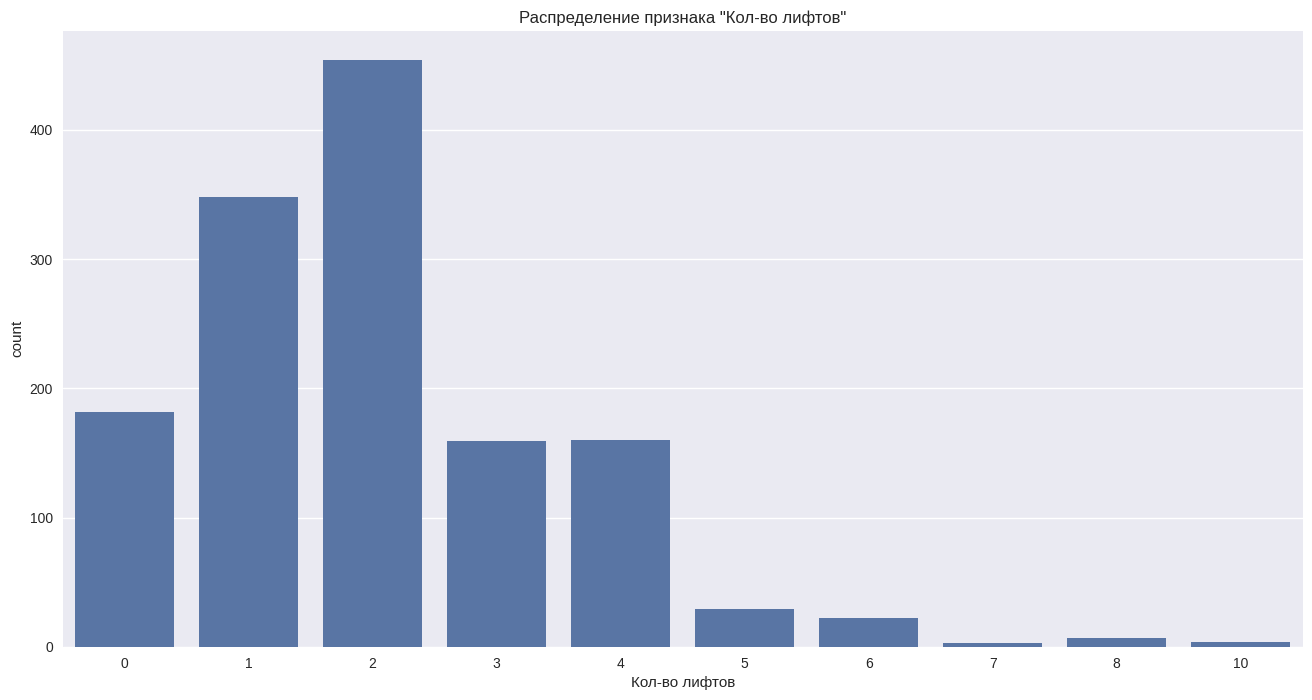

In [63]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))
sns.countplot(data, x='Кол-во лифтов', ax=ax)
ax.set_title('Распределение признака "Кол-во лифтов"');

Давайте оставим составим группы по лифтам 1, 2, 3 и 4+.

In [64]:
def elevator_preprocessing(x):
  if x == 1:
    return '1'
  elif x == 2:
    return '2'
  elif x == 3:
    return '3'
  else:
    return '4+'

data['Кол-во лифтов'] = data['Кол-во лифтов'].apply(lambda x: elevator_preprocessing(x))

Таргет в разрезе этого признака:

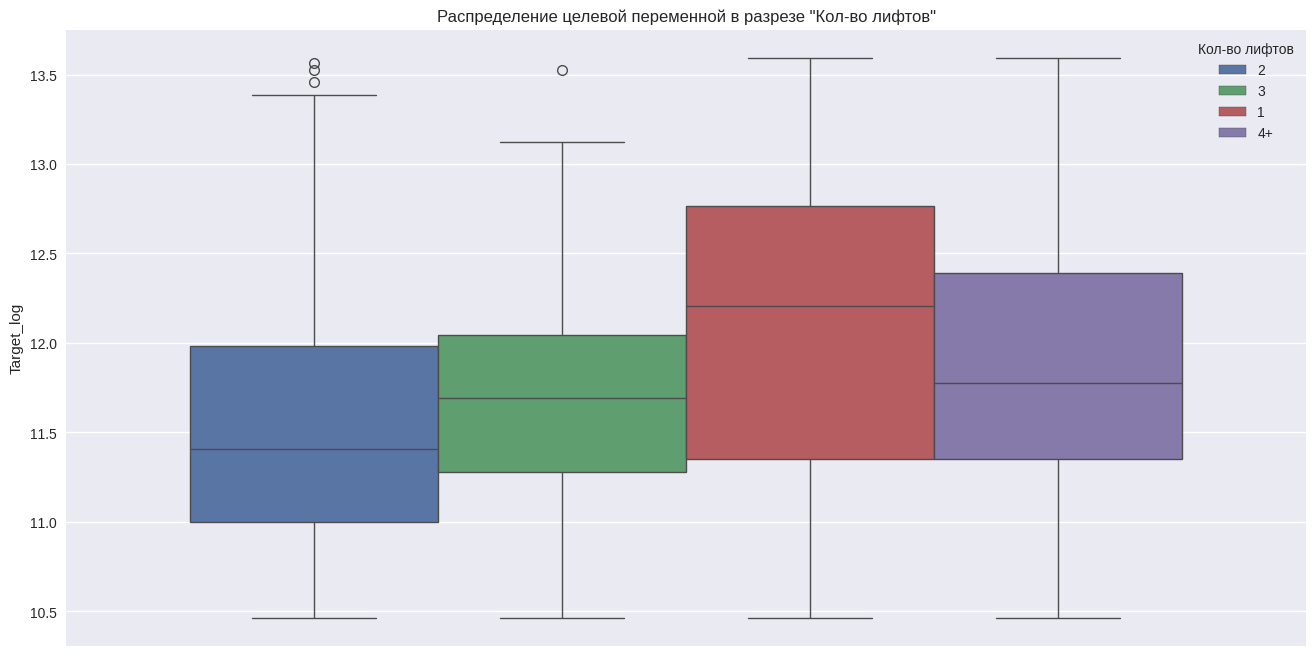

In [65]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))
sns.boxplot(data, y='Target_log', hue='Кол-во лифтов', ax=ax)
ax.set_title('Распределение целевой переменной в разрезе "Кол-во лифтов"');

Суди из данной визуализации кол-во лифтов в доме не влияет на стоимость аренды на квартиры.

Посмотрим на факт наличия грузового лифта.

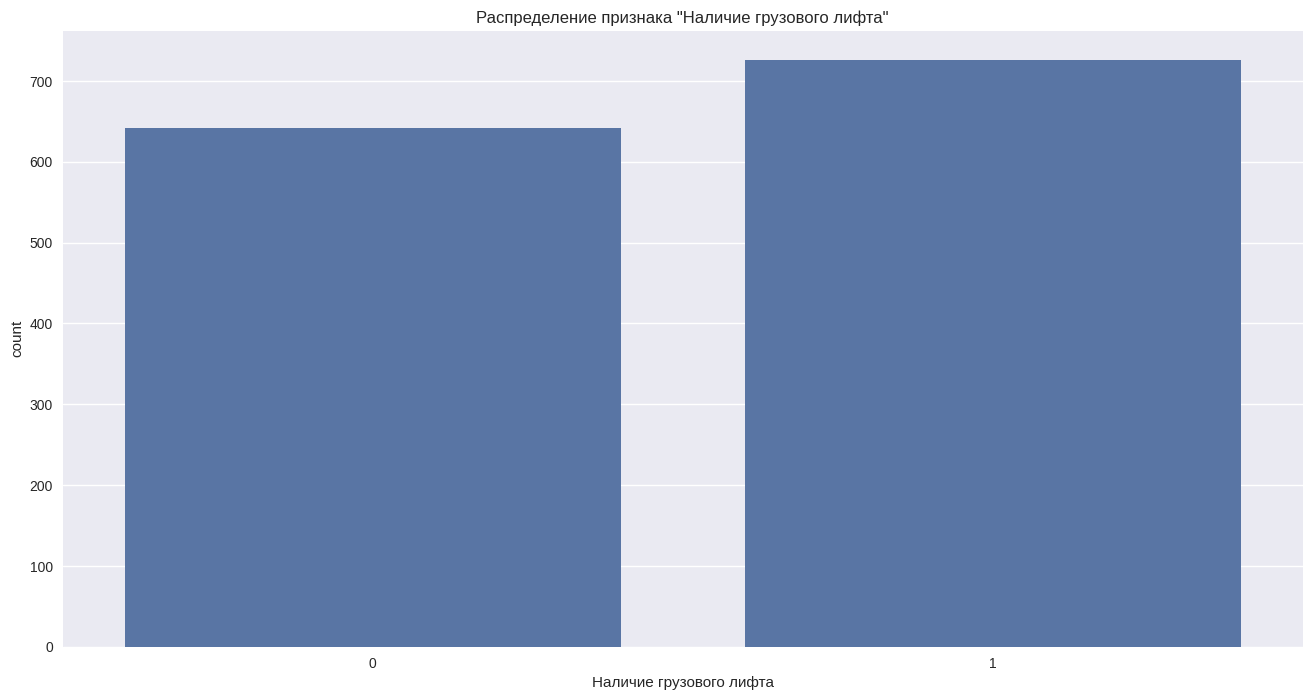

In [66]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))
sns.countplot(data, x='Наличие грузового лифта', ax=ax)
ax.set_title('Распределение признака "Наличие грузового лифта"');

Целевой признак в разрезе этого признака:

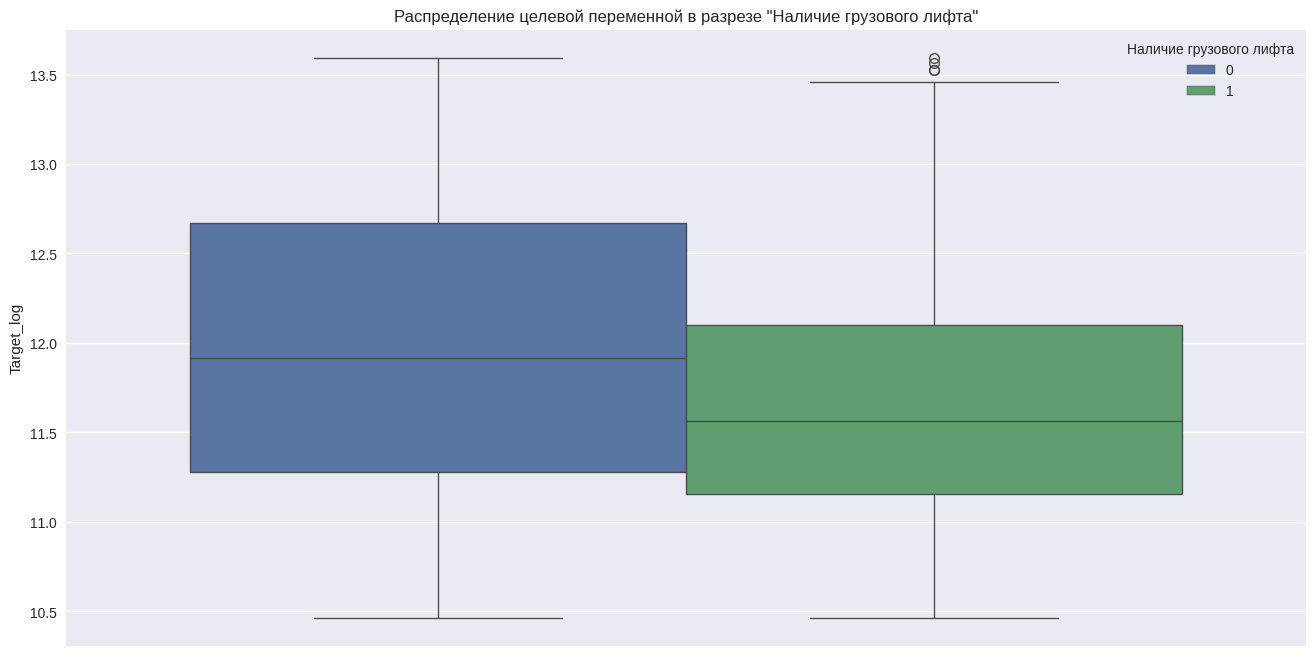

In [67]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))
sns.boxplot(data, y='Target_log', hue='Наличие грузового лифта', ax=ax)
ax.set_title('Распределение целевой переменной в разрезе "Наличие грузового лифта"');

Странно, но квартиры, которые находятся в домах с грузовыми лифтами стоят меньше.

### **Парковка**

Посмотрим на то, какие значения присутствуют в признаке:

In [68]:
data['Парковка'].unique().tolist()

['underground', 'ground', 'open', 'multilevel']

Распределение признака:

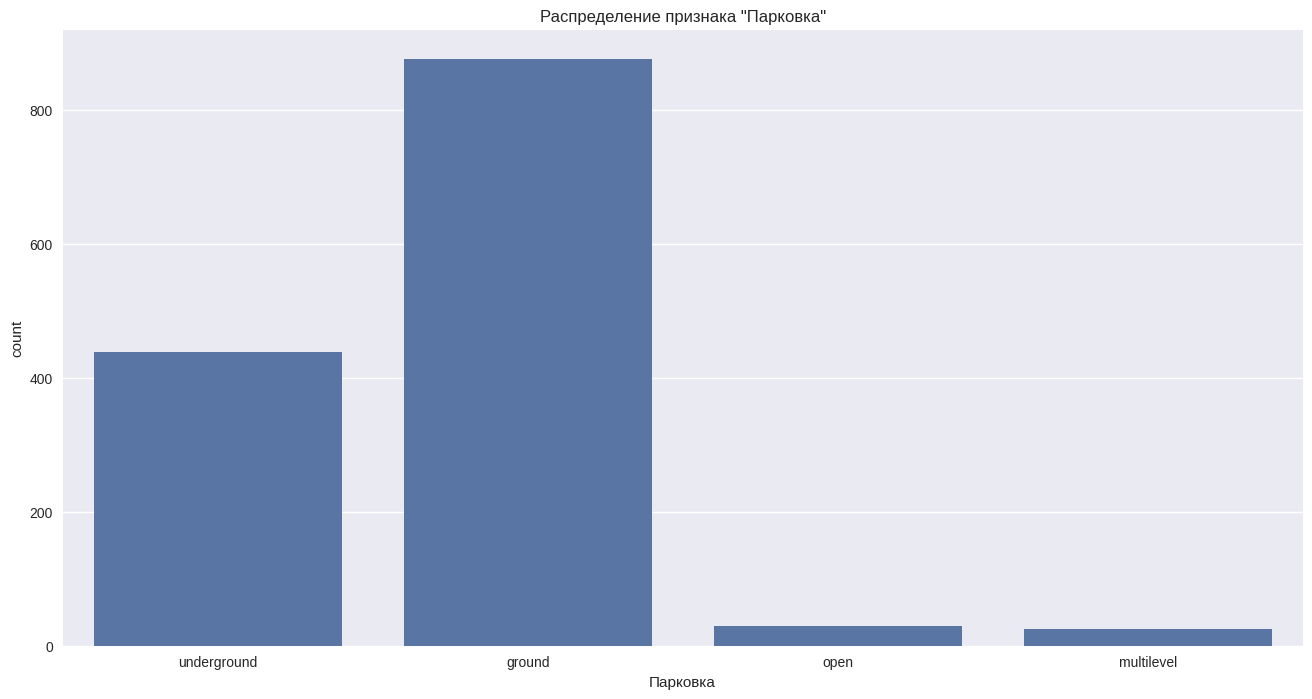

In [69]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))
sns.countplot(data, x='Парковка', ax=ax)
ax.set_title('Распределение признака "Парковка"');

В данных очень мало наблюдений, которые относятся к классам open и multilevel, давайте объеденим их с классом ground.

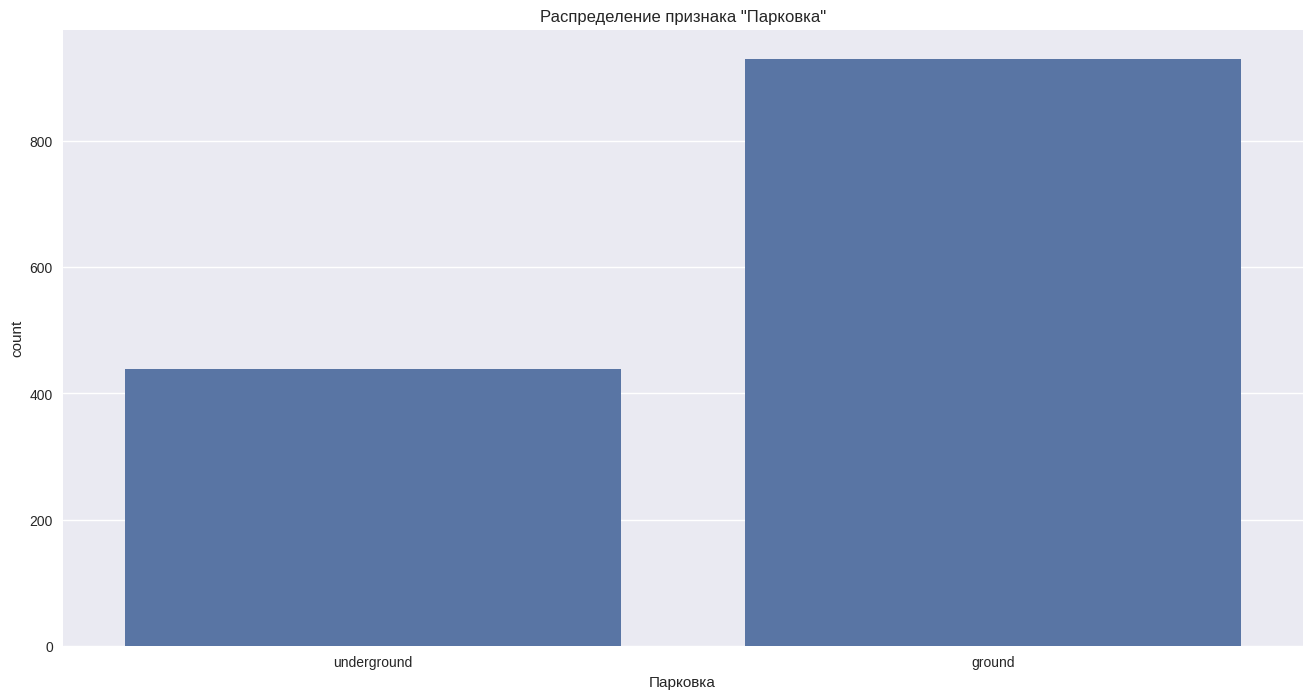

In [70]:
data['Парковка'] = data['Парковка'].apply(lambda x: 'ground' if x == 'open' or x == 'multilevel' else x)

fig, ax = plt.subplots(1, 1, figsize=(16, 8))
sns.countplot(data, x='Парковка', ax=ax)
ax.set_title('Распределение признака "Парковка"');

Посмотрим на таргет относительно признака "Парковка":

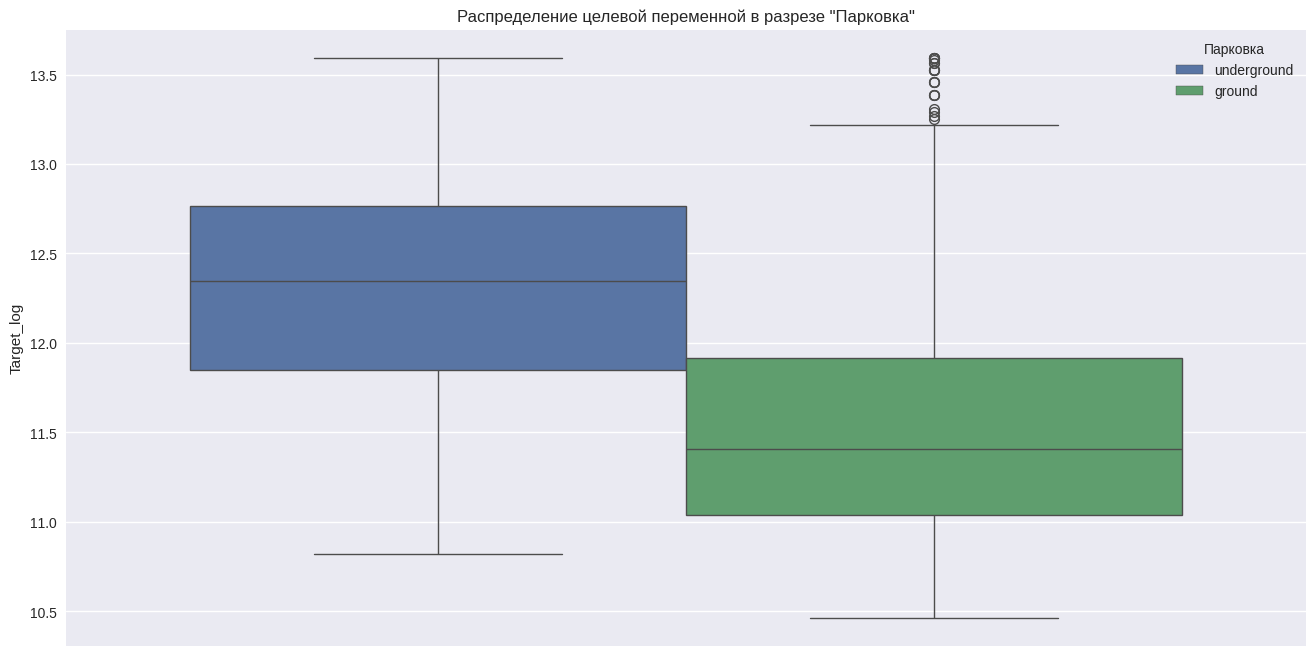

In [71]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))
sns.boxplot(data, y='Target_log', hue='Парковка', ax=ax)
ax.set_title('Распределение целевой переменной в разрезе "Парковка"');

Итак, можно сделать вывод, что квартиры, которые находятся в домах с подземной парковкой сдают дороже, чем с наземной.

## Подготовка данных к обучению модели

Нам необходимо закодировать категориальные признаки и проверить данные на мультиколлинеарность, перед тем, как начать обучать модель. Также разобьем данные на тестовую и обучающую выборки.

Посмотрим еще раз на информацию о наших данных.

In [72]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1368 entries, 0 to 1499
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Этаж                     1368 non-null   int64  
 1   Кол-во этажей            1368 non-null   int64  
 2   Кол-во комнат            1368 non-null   int64  
 3   Наличие мебели           1368 non-null   bool   
 4   Округ                    1368 non-null   object 
 5   Ближайшее метро, мин.    1368 non-null   float64
 6   Стоимость, мес.          1368 non-null   int64  
 7   Продажа от агента        1368 non-null   bool   
 8   Парковка                 1368 non-null   object 
 9   Target_log               1368 non-null   float64
 10  Последний этаж           1368 non-null   float64
 11  Первый этаж              1368 non-null   float64
 12  Площадь_log              1368 non-null   float64
 13  Жилая_площадь_log        1368 non-null   float64
 14  Площадь_кухни_log        1368

Сначала закодируем признаки наличие мебели и продажа от агента:

In [73]:
data['Наличие мебели'] = data['Наличие мебели'].apply(lambda x: 1 if x == True else 0)
data['Продажа от агента'] = data['Продажа от агента'].apply(lambda x: 1 if x == True else 0)
data.head()

,Этаж,Кол-во этажей,Кол-во комнат,Наличие мебели,Округ,"Ближайшее метро, мин.","Стоимость, мес.",Продажа от агента,Парковка,Target_log,Последний этаж,Первый этаж,Площадь_log,Жилая_площадь_log,Площадь_кухни_log,Наличие балкона,Кол-во лифтов,Наличие грузового лифта
0,20,23,3,1,other,4.0,168800,1,underground,12.036476,0.0,0.0,4.330733,3.839452,2.397895,0,2,1
2,23,23,1,1,НАО (Новомосковский),2.0,60000,1,ground,11.002117,1.0,0.0,3.761200,2.944439,2.302585,0,3,0
3,8,10,3,1,ЦАО,3.0,400000,1,underground,12.899222,0.0,0.0,4.836282,4.290459,2.833213,0,1,0
4,45,75,3,1,ЦАО,3.0,570000,1,underground,13.253393,0.0,0.0,4.795791,4.795791,3.713572,0,4+,1
5,15,19,1,1,НАО (Новомосковский),4.0,65000,0,ground,11.082158,0.0,0.0,3.713572,3.713572,2.397895,0,2,1


Теперь закодируем признаки округа, парковки и кол-ва лифтов для этого воспользуемся OneHotEncoding.

In [74]:
#Перед преобразованием сохраним данные для pipeline
data_pipeline = data.copy()
#Выбираем категориальные признаки
cat_features = data.select_dtypes(include=['object']).columns
#Создаем экземпляр BinaryEncoder
encoder = ce.OneHotEncoder(cols=cat_features, use_cat_names=True) # указываем столбец для кодирования
type_bin = encoder.fit_transform(data[cat_features])
data = pd.concat([data, type_bin], axis=1)

#Удаляем оригинальные категориальные признаки
data.drop(cat_features, axis=1, inplace=True)
print(f'Shape of data: {data.shape}')
data.head()

Shape of data: (1368, 26)


,Этаж,Кол-во этажей,Кол-во комнат,Наличие мебели,"Ближайшее метро, мин.","Стоимость, мес.",Продажа от агента,Target_log,Последний этаж,Первый этаж,...,Округ_НАО (Новомосковский),Округ_ЦАО,Округ_ЗАО,Округ_САО,Парковка_underground,Парковка_ground,Кол-во лифтов_2,Кол-во лифтов_3,Кол-во лифтов_1,Кол-во лифтов_4+
0,20,23,3,1,4.0,168800,1,12.036476,0.0,0.0,...,0,0,0,0,1,0,1,0,0,0
2,23,23,1,1,2.0,60000,1,11.002117,1.0,0.0,...,1,0,0,0,0,1,0,1,0,0
3,8,10,3,1,3.0,400000,1,12.899222,0.0,0.0,...,0,1,0,0,1,0,0,0,1,0
4,45,75,3,1,3.0,570000,1,13.253393,0.0,0.0,...,0,1,0,0,1,0,0,0,0,1
5,15,19,1,1,4.0,65000,0,11.082158,0.0,0.0,...,1,0,0,0,0,1,1,0,0,0


Чтобы проверить данные на мультиколлинеарность, посмотрим на матрицу корреляций.

Text(0.5, 1.0, 'Матрица корреляций')

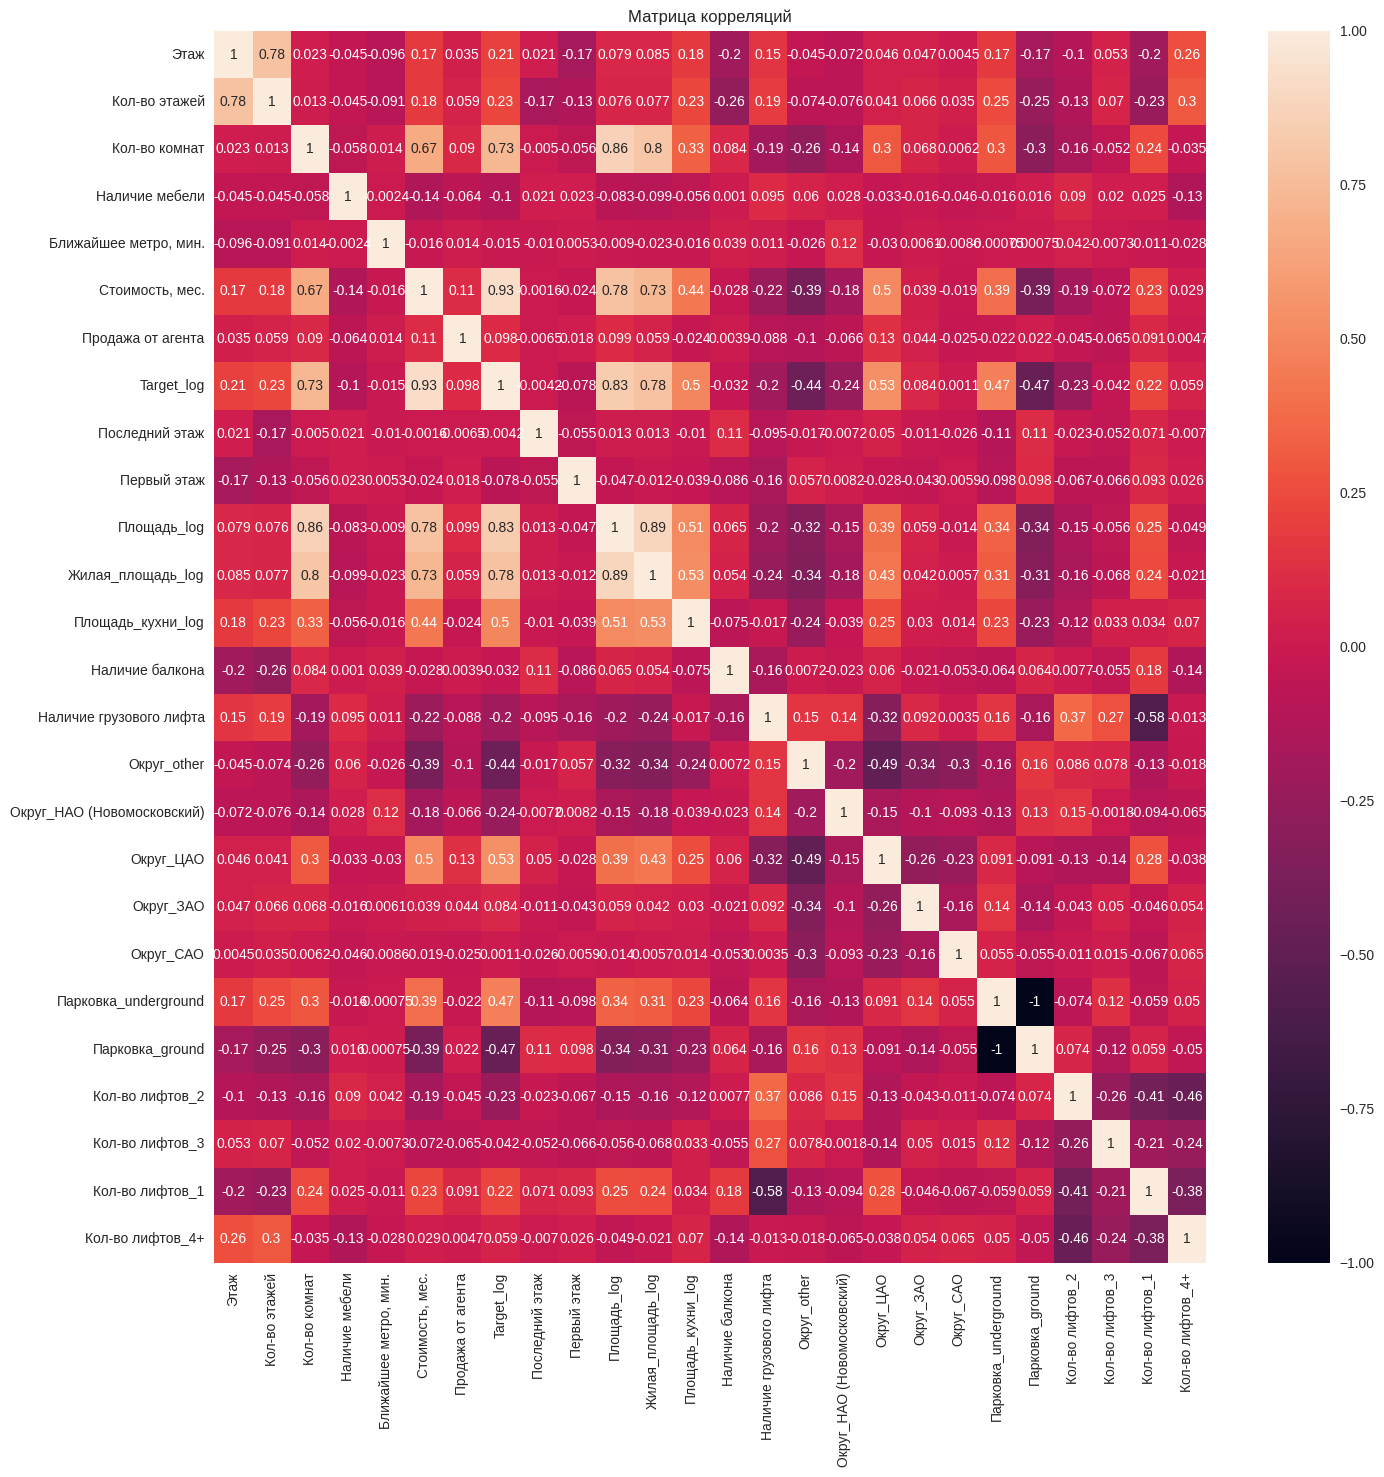

In [75]:
matrix = data.corr()

fig, ax = plt.subplots(1, 1, figsize=(16, 16))
sns.heatmap(data=matrix, ax=ax, annot=True)
ax.set_title('Матрица корреляций')

Разбиваем данные на тестовую и обучающую выборки.

In [76]:
X = data.drop(['Стоимость, мес.', 'Target_log'], axis=1) #Матрица наблюдений
y = data['Target_log'] #Вектор правильных ответов

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_seed)
print(f'Train shape: {X_train.shape}')
print(f'Test shape: {X_test.shape}')

Train shape: (1094, 24)
Test shape: (274, 24)


Также данные необходимо отмасштабировать.

In [77]:
#Обучаем MinMaxScaler
scaler = preprocessing.MinMaxScaler()
scaler.fit(X_train)
#Нормализуем данные
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

#Ответы для метрик
y_train_for_metrics = np.exp(y_train) + 1
y_test_for_metrics  = np.exp(y_test) + 1

## Построение модели

В качестве метрик для оценки наших моделей будем использовать MAPE и MAE.

Для начала построим baseline в виде линейной регрессии, чтобы посмотреть решается ли наша задача и оценить можно ли ее решить простыми моделями.

In [78]:
#Обучаем модель
lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)
#Строим предсказания и выводим метрики
y_train_pred = np.exp(lr_model.predict(X_train_scaled)) + 1
y_test_pred = np.exp(lr_model.predict(X_test_scaled)) + 1
print(f'Train MAPE: {round(metrics.mean_absolute_percentage_error(y_train_for_metrics, y_train_pred) * 100, 2)}')
print(f'Test MAPE: {round(metrics.mean_absolute_percentage_error(y_test_for_metrics, y_test_pred) * 100, 2)}')
print(f'Train MAE: {round(metrics.mean_absolute_error(y_train_for_metrics, y_train_pred), 2)}')
print(f'Test MAE: {round(metrics.mean_absolute_error(y_test_for_metrics, y_test_pred), 2)}')

Train MAPE: 24.82
Test MAPE: 24.85
Train MAE: 46987.12
Test MAE: 45577.4


Модель дает давольно слабые результаты, посмотрим, как с этой задачей справится дерево решений.

In [79]:
#Модель
dt_model = DecisionTreeRegressor(random_state=random_seed)
#Сетка параметров
param_grid = {
    'max_depth': np.arange(1, 100, 10),
    'min_samples_leaf': np.arange(1, 20, 4),
}
#Подбор гиперпараметров
grid_dt = RandomizedSearchCV(
    estimator=dt_model,
    param_distributions=param_grid,
    cv=5,
    n_iter=10,
    verbose=2,
    n_jobs=-1
)
#Обучаем модель
grid_dt.fit(X_train_scaled, y_train)
print(f'best params: {grid_dt.best_params_}')
dt_model = grid_dt.best_estimator_
#Строим предсказания и выводим метрики
y_train_pred = np.exp(dt_model.predict(X_train_scaled)) + 1
y_test_pred = np.exp(dt_model.predict(X_test_scaled)) + 1
print(f'Train MAPE: {round(metrics.mean_absolute_percentage_error(y_train_for_metrics, y_train_pred) * 100, 2)}')
print(f'Test MAPE: {round(metrics.mean_absolute_percentage_error(y_test_for_metrics, y_test_pred) * 100, 2)}')
print(f'Train MAE: {round(metrics.mean_absolute_error(y_train_for_metrics, y_train_pred), 2)}')
print(f'Test MAE: {round(metrics.mean_absolute_error(y_test_for_metrics, y_test_pred), 2)}')

Fitting 5 folds for each of 10 candidates, totalling 50 fits
best params: {'min_samples_leaf': 17, 'max_depth': 81}
Train MAPE: 23.94
Test MAPE: 28.27
Train MAE: 44377.1
Test MAE: 49063.88


Модель немного переобучилась.

Воспользуемся более сильными моделями, например, случайным лесом.


In [80]:
#Модель
rf_model = RandomForestRegressor(min_samples_leaf=17, max_depth=71, random_state=random_seed)
#Сетка параметров
param_grid = {
    'n_estimators': np.arange(100, 301, 100)
}
#Подбор гиперпараметров
grid_rf = RandomizedSearchCV(
    estimator=rf_model,
    param_distributions=param_grid,
    cv=2,
    n_iter=3,
    verbose=2,
    n_jobs=-1
)
#Обучаем модель
grid_rf.fit(X_train_scaled, y_train)
print(f'best params: {grid_rf.best_params_}')
rf_model = grid_rf.best_estimator_
#Строим предсказания и выводим метрики
y_train_pred = np.exp(rf_model.predict(X_train_scaled)) + 1
y_test_pred = np.exp(rf_model.predict(X_test_scaled)) + 1
print(f'Train MAPE: {round(metrics.mean_absolute_percentage_error(y_train_for_metrics, y_train_pred) * 100, 2)}')
print(f'Test MAPE: {round(metrics.mean_absolute_percentage_error(y_test_for_metrics, y_test_pred) * 100, 2)}')
print(f'Train MAE: {round(metrics.mean_absolute_error(y_train_for_metrics, y_train_pred), 2)}')
print(f'Test MAE: {round(metrics.mean_absolute_error(y_test_for_metrics, y_test_pred), 2)}')

Fitting 2 folds for each of 3 candidates, totalling 6 fits
best params: {'n_estimators': 300}
Train MAPE: 22.94
Test MAPE: 25.23
Train MAE: 43964.52
Test MAE: 43926.63


Очевидно, что модель справляется лучше, чем предыдущие две.

Давайте попробуем применить бустинг.

In [81]:
# Реализация функции оптимизации гиперпараметров с помощью Optuna
def optuna_XGB(trial):
    # Задаем пространство поиска гиперпараметров
    max_depth = trial.suggest_int('max_depth', 2, 10)
    min_child_weight = trial.suggest_int('min_child_weight', 1, 5)
    subsample = trial.suggest_float('subsample', 0.5, 1.0)
    colsample_bytree = trial.suggest_float('colsample_bytree', 0.5, 1.0)
    learning_rate = trial.suggest_float('learning_rate', 0.01, 0.3)
    gamma = trial.suggest_float('gamma', 0.0, 0.5)

    # Создаем модель
    opt_model = xgb.XGBRegressor(
        max_depth=max_depth,
        min_child_weight=min_child_weight,
        colsample_bytree=colsample_bytree,
        subsample=subsample,
        learning_rate=learning_rate,
        gamma=gamma,
        random_state=random_seed,
        objective='reg:squarederror')  # Указываем objective для регрессии

    # Обучаем модель
    opt_model.fit(X_train_scaled, y_train)

    # Воспользуемся метрикой MAE для поиска лучших гиперпараметров
    y_train_pred = opt_model.predict(X_train_scaled)
    score = metrics.mean_absolute_error(y_train, y_train_pred)

    return score

# Поиск оптимальных гиперпараметров
sampler = optuna.samplers.TPESampler(seed=random_seed)
study = optuna.create_study(
    sampler=sampler, study_name='XGBRegressor', direction='minimize')  # Направление 'minimize' для минимизации MAE
study.optimize(optuna_XGB, n_trials=50)

print(f'Лучшие параметры:\n{study.best_params}')

[I 2024-12-08 20:23:57,058] A new study created in memory with name: XGBRegressor
[I 2024-12-08 20:23:57,191] Trial 0 finished with value: 0.1547178107642594 and parameters: {'max_depth': 5, 'min_child_weight': 5, 'subsample': 0.8659969709057025, 'colsample_bytree': 0.7993292420985183, 'learning_rate': 0.055245405728306586, 'gamma': 0.07799726016810132}. Best is trial 0 with value: 0.1547178107642594.
[I 2024-12-08 20:23:57,232] Trial 1 finished with value: 0.3108609442399915 and parameters: {'max_depth': 2, 'min_child_weight': 5, 'subsample': 0.8005575058716043, 'colsample_bytree': 0.8540362888980227, 'learning_rate': 0.01596950334578271, 'gamma': 0.48495492608099716}. Best is trial 0 with value: 0.1547178107642594.
[I 2024-12-08 20:23:57,288] Trial 2 finished with value: 0.17536170482440241 and parameters: {'max_depth': 9, 'min_child_weight': 2, 'subsample': 0.5909124836035503, 'colsample_bytree': 0.5917022549267169, 'learning_rate': 0.09823025045826593, 'gamma': 0.2623782158161189}.

Лучшие параметры:
{'max_depth': 9, 'min_child_weight': 4, 'subsample': 0.8352222257254392, 'colsample_bytree': 0.7787600610872776, 'learning_rate': 0.296720446690495, 'gamma': 0.0005119906782924996}


In [82]:
xgb_model  = xgb.XGBRegressor(
    learning_rate=0.2821965103663452, # темп обучения
    max_depth=1, # Максимальная глубина каждого дерева
    min_child_weight=4, # Минимальное количество объектов в листовой вершине
    gamma=0.0005119906782924996, # Минимальное уменьшение функции потерь, необходимое для разделения дерева
    colsample_bytree=0.5934457960417318, # Доля признаков, используемых при построении каждого дерева
    subsample=0.8352222257254392, # Доля обучающих данных, используемых для обучения каждого дерева
    random_state=random_seed # генератор случайных чисел
)
#Обучаем модель
xgb_model.fit(X_train_scaled, y_train)

#Строим предсказания и выводим метрики
y_train_pred = np.exp(xgb_model.predict(X_train_scaled)) + 1
y_test_pred = np.exp(xgb_model.predict(X_test_scaled)) + 1
print(f'Train MAPE: {round(metrics.mean_absolute_percentage_error(y_train_for_metrics, y_train_pred) * 100, 2)}')
print(f'Test MAPE: {round(metrics.mean_absolute_percentage_error(y_test_for_metrics, y_test_pred) * 100, 2)}')
print(f'Train MAE: {round(metrics.mean_absolute_error(y_train_for_metrics, y_train_pred), 2)}')
print(f'Test MAE: {round(metrics.mean_absolute_error(y_test_for_metrics, y_test_pred), 2)}')

Train MAPE: 23.38
Test MAPE: 25.21
Train MAE: 44330.43
Test MAE: 45270.74


In [83]:
def cat_reg(trial):
    params = {
        "iterations": 1000,
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
        "depth": trial.suggest_int("depth", 1, 10),
        "subsample": trial.suggest_float("subsample", 0.05, 1.0),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.05, 1.0),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 100),
    }

    opt_model = catboost.CatBoostRegressor(**params, random_state=42, silent=True)
    # Обучаем модель
    opt_model.fit(X_train_scaled, y_train)
    # Воспользуемся метрикой MSE для поиска лучших гиперпараметров
    y_train_pred = opt_model.predict(X_train_scaled)
    score = metrics.mean_squared_error(y_train, y_train_pred)

    return score


# Поиск оптимальных гиперпараметров
sampler = optuna.samplers.TPESampler(seed=42)
study = optuna.create_study(
    sampler=sampler, study_name='CatBoostRegressor', direction='minimize')  # Направление 'minimize' для минимизации MSE
study.optimize(cat_reg, n_trials=50)

print(f'Лучшие параметры:\n{study.best_params}')

[I 2024-12-08 20:24:03,500] A new study created in memory with name: CatBoostRegressor
[I 2024-12-08 20:24:17,231] Trial 0 finished with value: 0.04416292888783904 and parameters: {'learning_rate': 0.005611516415334507, 'depth': 10, 'subsample': 0.7453942447208348, 'colsample_bylevel': 0.6187255599871848, 'min_data_in_leaf': 16}. Best is trial 0 with value: 0.04416292888783904.
[I 2024-12-08 20:24:17,866] Trial 1 finished with value: 0.18261008044396274 and parameters: {'learning_rate': 0.002051110418843397, 'depth': 1, 'subsample': 0.8728673384861885, 'colsample_bylevel': 0.6210592611560484, 'min_data_in_leaf': 71}. Best is trial 0 with value: 0.04416292888783904.
[I 2024-12-08 20:24:29,775] Trial 2 finished with value: 0.1803050116914824 and parameters: {'learning_rate': 0.0010994335574766201, 'depth': 10, 'subsample': 0.8408205087604007, 'colsample_bylevel': 0.25172215514436236, 'min_data_in_leaf': 19}. Best is trial 0 with value: 0.04416292888783904.
[I 2024-12-08 20:24:30,890] Tri

Лучшие параметры:
{'learning_rate': 0.09987845185373238, 'depth': 10, 'subsample': 0.9572159933322091, 'colsample_bylevel': 0.418516727051782, 'min_data_in_leaf': 58}


In [84]:
cat_model = catboost.CatBoostRegressor(
    iterations=1000,
    learning_rate=0.09987845185373238,
    depth=1,
    subsample=0.9572159933322091,
    colsample_bylevel=0.418516727051782,
    min_data_in_leaf=58
)
# Обучаем модель
cat_model.fit(X_train_scaled, y_train)

#Строим предсказания и выводим метрики
y_train_pred = np.exp(cat_model.predict(X_train_scaled)) + 1
y_test_pred = np.exp(cat_model.predict(X_test_scaled)) + 1
print(f'Train MAPE: {round(metrics.mean_absolute_percentage_error(y_train_for_metrics, y_train_pred) * 100, 2)}')
print(f'Test MAPE: {round(metrics.mean_absolute_percentage_error(y_test_for_metrics, y_test_pred) * 100, 2)}')
print(f'Train MAE: {round(metrics.mean_absolute_error(y_train_for_metrics, y_train_pred), 2)}')
print(f'Test MAE: {round(metrics.mean_absolute_error(y_test_for_metrics, y_test_pred), 2)}')

0:	learn: 0.7171256	total: 307us	remaining: 307ms
1:	learn: 0.6819633	total: 1.1ms	remaining: 548ms
2:	learn: 0.6521958	total: 1.55ms	remaining: 515ms
3:	learn: 0.6261847	total: 3.16ms	remaining: 788ms
4:	learn: 0.6172322	total: 3.62ms	remaining: 721ms
5:	learn: 0.5979616	total: 4.57ms	remaining: 757ms
6:	learn: 0.5856685	total: 5.04ms	remaining: 715ms
7:	learn: 0.5636842	total: 5.68ms	remaining: 705ms
8:	learn: 0.5491281	total: 6.11ms	remaining: 673ms
9:	learn: 0.5370229	total: 6.52ms	remaining: 646ms
10:	learn: 0.5189258	total: 6.94ms	remaining: 624ms
11:	learn: 0.5052399	total: 7.38ms	remaining: 607ms
12:	learn: 0.4929813	total: 7.79ms	remaining: 591ms
13:	learn: 0.4810368	total: 8.26ms	remaining: 582ms
14:	learn: 0.4700195	total: 8.72ms	remaining: 573ms
15:	learn: 0.4612500	total: 9.21ms	remaining: 566ms
16:	learn: 0.4541383	total: 9.65ms	remaining: 558ms
17:	learn: 0.4483595	total: 9.88ms	remaining: 539ms
18:	learn: 0.4400657	total: 10.4ms	remaining: 536ms
19:	learn: 0.4332111	tot

Наилучший результат на тесте показала модель XGBoost ее и будем использовать в продакшене.

## Подготовка модели к продакшену

Продуктом проекта является Telegram-бот, поэтому нам необходимо создать функцию, которая будет преобразовывать данные, полученные от бота, и возвращать предсказание модели. Чтобы каждый раз не обучать модель, давайте сериализуем полученную раннее и будем использовать ее в дальнейшем.

Заметим, что мы проделывали с нашими данными преобразования, такие как
кодирование, и масштабирование, нам также надо будет повторять эти действия, поэтому построим пайплайн.

In [85]:
X = data_pipeline.drop(['Стоимость, мес.', 'Target_log'], axis=1) #Матрица наблюдений
y = data_pipeline['Target_log'] #Вектор правильных ответов

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_seed)
print(f'Train shape: {X_train.shape}')
print(f'Test shape: {X_test.shape}')

#Строим pipeline
pipeline = Pipeline(
    [('encoder', encoder),
     ('scaler', scaler),
     ('model', xgb_model)]
)
#Обучаем pipeline
pipeline.fit(X_train, y_train)

#Строим предсказания и выводим метрики
y_train_pred = np.exp(pipeline.predict(X_train)) + 1
y_test_pred = np.exp(pipeline.predict(X_test)) + 1
print(f'Train MAPE: {round(metrics.mean_absolute_percentage_error(y_train_for_metrics, y_train_pred) * 100, 2)}')
print(f'Test MAPE: {round(metrics.mean_absolute_percentage_error(y_test_for_metrics, y_test_pred) * 100, 2)}')
print(f'Train MAE: {round(metrics.mean_absolute_error(y_train_for_metrics, y_train_pred), 2)}')
print(f'Test MAE: {round(metrics.mean_absolute_error(y_test_for_metrics, y_test_pred), 2)}')

Train shape: (1094, 16)
Test shape: (274, 16)
Train MAPE: 23.51
Test MAPE: 25.0
Train MAE: 44676.76
Test MAE: 45456.23


Теперь сериализуем наш пайплайн.

In [86]:
joblib.dump(pipeline, 'pipeline.joblib')

['pipeline.joblib']

Напишишем функцию, которая будет принимать данные о квартире(в виде ответа пользователя) и возвращать предсказание.

In [108]:
#Десериализуем pipeline
pipeline = joblib.load('/content/pipeline.joblib')
user_answer = {'district': 'НАО (Новомосковский)',
               'nearest_underground': 20,
               'rooms_count': 4,
               'has_furniture': 0,
               'area': 90,
               'living_area': 85,
               'kitchen_area': 15,
               'floors_count': 12,
               'floor': 5,
               'parking_type': 'ground',
               'has_balconies': 1,
               'lifts_count': '3',
               'has_cargo_lifts': 1,
               'is_seller_agent': 0}

#Функция предобработки полученных данных
def preprocessing_data(user_answer):
  #Названия столбцов
  cols_names = ['Этаж',
                'Кол-во этажей',
                'Кол-во комнат',
                'Наличие мебели',
                'Округ',
                'Ближайшее метро, мин.',
                'Продажа от агента',
                'Парковка',
                'Последний этаж',
                'Первый этаж',
                'Площадь_log',
                'Жилая_площадь_log',
                'Площадь_кухни_log',
                'Наличие балкона',
                'Кол-во лифтов',
                'Наличие грузового лифта']
  #Генерация признаков последнего и первого этажей
  if user_answer['floor'] == user_answer['floors_count']:
    last_floor = 1
  else:
    last_floor = 0
  if user_answer['floor'] == 1:
    first_floor = 1
  else:
    first_floor = 0
  #Значения столбцов
  cols_values = np.array([user_answer['floor'],
          user_answer['floors_count'],
          user_answer['rooms_count'],
          user_answer['has_furniture'],
          user_answer['district'],
          user_answer['nearest_underground'],
          user_answer['is_seller_agent'],
          user_answer['parking_type'],
          last_floor,
          first_floor,
          np.log(user_answer['area']),
          np.log(user_answer['living_area']),
          np.log(user_answer['kitchen_area']),
          user_answer['has_balconies'],
          user_answer['lifts_count'],
          user_answer['has_cargo_lifts']]).reshape(1, 16)

  user_data = pd.DataFrame(cols_values, columns=cols_names)
  return user_data

#Функция, возвращающая предсказание
def get_predictions(user_answer):
  user_data = preprocessing_data(user_answer)
  predict = np.exp(pipeline.predict(user_data)) + 1
  return predict

print(get_predictions(user_answer))

[143711.61]
